# Exploratory Data Analysis of Hospital Supply Chain Dataset

This project aims to perform an exploratory data analysis of the hospital supply chain dataset available at the Kaggle website under the following link: https://www.kaggle.com/datasets/vanpatangan/hospital-supply-chain/data. The dataset was chosen for this project because it provides relevant data, which is also stored in several files, resembling the situation from everyday life where data is stored in multiple tables across a database or different systems.

Let's start with importing libraries.

In [465]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta, time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline

Next step is importing data files and examining the structure of the files and what information is stored in each of the table.

In [466]:
financial_df = pd.read_csv("financial_data.csv")
patient_df   = pd.read_csv("patient_data.csv")
staff_df     = pd.read_csv("staff_data.csv")
vendor_df    = pd.read_csv("vendor_data.csv")
inventory_df = pd.read_csv("inventory_data.csv")

for name, df in {"Financial": financial_df, "Patient": patient_df,
                 "Staff": staff_df, "Vendor": vendor_df, "Inventory": inventory_df}.items():
    print(f"\n{name} Dataset:")
    print(df.shape)
    print(df.head(3))


Financial Dataset:
(500, 4)
         Date Expense_Category    Amount     Description
0  2024-10-01         Staffing  29391.86  Surgical masks
1  2024-10-02         Supplies  47757.71  Surgical masks
2  2024-10-03         Supplies  43996.60     Ventilators

Patient Dataset:
(500, 10)
  Patient_ID       Admission_Date       Discharge_Date Primary_Diagnosis   
0       P001  2024-10-06 05:30:28  2024-10-23 01:11:34          Diabetes  \
1       P002  2024-10-24 11:07:58  2024-10-15 05:16:54          Fracture   
2       P003  2024-10-22 21:43:43  2024-10-24 10:56:30          Fracture   

  Procedure_Performed     Room_Type  Bed_Days Supplies_Used  Equipment_Used   
0        Appendectomy  General Ward         2    Gloves, IV  Surgical Table  \
1        Appendectomy           ICU        10      Gown, IV     MRI Machine   
2         Chest X-ray           ICU        10    Gloves, IV   X-ray Machine   

        Staff_Needed  
0         2 Surgeons  
1            1 Nurse  
2  1 Nurse, 1 Doctor  



The data consists of 5 files and each one of them stores information about one aspect of hospital management including information about financial and inventory data, as well as patient, staff and vendors information.

The next step is to change every column which consists date in string format to date format.

In [467]:
dfs = {
    "Financial": financial_df,
    "Patient": patient_df,
    "Staff": staff_df,
    "Vendor": vendor_df,
    "Inventory": inventory_df
}

for name, df in dfs.items():
    for col in df.columns:
        if "date" in col.lower():
            df[col] = pd.to_datetime(df[col], errors="coerce")


Also every table is checked for missing values

In [468]:
financial_df.isnull().sum(), patient_df.isnull().sum(), staff_df.isnull().sum(), vendor_df.isnull().sum(), inventory_df.isnull().sum()

(Date                0
 Expense_Category    0
 Amount              0
 Description         0
 dtype: int64,
 Patient_ID             0
 Admission_Date         0
 Discharge_Date         0
 Primary_Diagnosis      0
 Procedure_Performed    0
 Room_Type              0
 Bed_Days               0
 Supplies_Used          0
 Equipment_Used         0
 Staff_Needed           0
 dtype: int64,
 Staff_ID              0
 Staff_Type            0
 Shift_Date            0
 Shift_Start_Time      0
 Shift_End_Time        0
 Current_Assignment    0
 Hours_Worked          0
 Patients_Assigned     0
 Overtime_Hours        0
 dtype: int64,
 Vendor_ID               0
 Vendor_Name             0
 Item_Supplied           0
 Avg_Lead_Time (days)    0
 Cost_Per_Item           0
 Last_Order_Date         0
 Next_Delivery_Date      0
 dtype: int64,
 Date                 0
 Item_ID              0
 Item_Type            0
 Item_Name            0
 Current_Stock        0
 Min_Required         0
 Max_Capacity         0
 Unit_

Next step is to check time period which data describes, as it will answer the question of which is the researched period

In [469]:
def date_range_summary(df, date_cols, name):
    print(f"{name} Dataset")
    for col in date_cols:
        if col in df.columns:
            print(f" - {col}: {df[col].min()} → {df[col].max()}")

date_range_summary(financial_df, ["Date"], "Financial")
date_range_summary(patient_df, ["Admission_Date", "Discharge_Date"], "Patient")
date_range_summary(staff_df, ["Shift_Date"], "Staff")
date_range_summary(vendor_df, ["Last_Order_Date", "Next_Delivery_Date"], "Vendor")
date_range_summary(inventory_df, ["Date"], "Inventory")

Financial Dataset
 - Date: 2024-10-01 00:00:00 → 2026-02-12 00:00:00
Patient Dataset
 - Admission_Date: 2024-10-01 02:53:00 → 2024-10-29 22:28:36
 - Discharge_Date: 2024-10-05 00:33:07 → 2024-10-31 21:33:24
Staff Dataset
 - Shift_Date: 2024-10-01 01:13:46 → 2024-10-29 23:18:39
Vendor Dataset
 - Last_Order_Date: 2024-09-01 00:00:00 → 2024-09-28 00:00:00
 - Next_Delivery_Date: 2024-10-03 00:00:00 → 2024-10-15 00:00:00
Inventory Dataset
 - Date: 2024-10-01 00:00:00 → 2026-02-12 00:00:00


The dataset spans two distinct categories of time periods:
1. Operational Data (short-term) – Covering the period 2024-10-01 to 2024-10-31, this includes the Patient Data, Staff Data, and Vendor Data, which capture day-to-day hospital activities such as admissions, staff shifts, and supplier transactions.
2. Planning & Long-Term Data – Extending from 2024-10-01 to 2026-02-12, this includes the Financial Data and Inventory Data, which provide broader insights into hospital costs and stock management over a longer horizon.

Given the structure of the data, it makes sense to concentrate research efforts on the month of October 2024. In this period, there is information on operational data and long-term data which will provide means to place operational data in context.

Before starting prediction and analysis, there will be several checks performed to check if data is valid and provides real information.
The checks will include:
1. If for every patient visit the admission date is before the discharge date
2. What is the spread of the staff between location

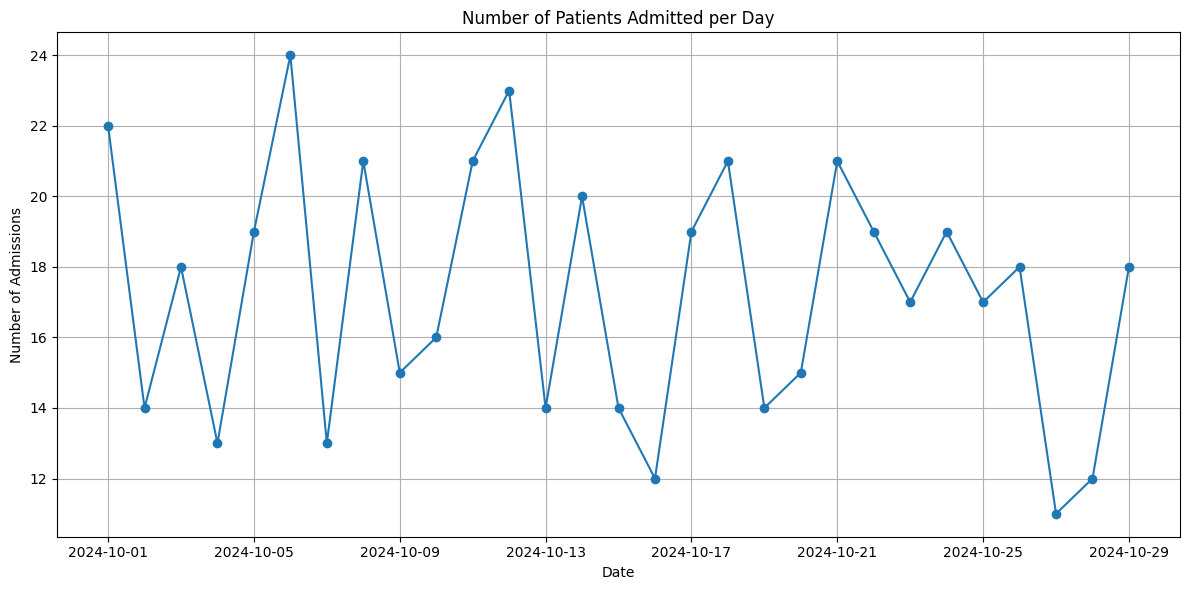

In [470]:
patient_df["Admission_Date"] = pd.to_datetime(patient_df["Admission_Date"], errors="coerce")

# Grouping by day and count admissions
admissions_per_day = (
    patient_df.groupby(patient_df["Admission_Date"].dt.date)["Patient_ID"]
    .count()
)

plt.figure(figsize=(12,6))
admissions_per_day.plot(kind="line", marker="o")

plt.title("Number of Patients Admitted per Day")
plt.xlabel("Date")
plt.ylabel("Number of Admissions")
plt.grid(True)
plt.tight_layout()
plt.show()


In [471]:
invalid_cases = patient_df[patient_df["Discharge_Date"] < patient_df["Admission_Date"]]
print("Number of cases with Discharge_Date before Admission_Date:", invalid_cases.shape[0])
print(invalid_cases.head())

print("The percantage of invalid cases in patient table is", invalid_cases.shape[0]/patient_df.shape[0],"%")

Number of cases with Discharge_Date before Admission_Date: 195
   Patient_ID      Admission_Date      Discharge_Date Primary_Diagnosis   
1        P002 2024-10-24 11:07:58 2024-10-15 05:16:54          Fracture  \
4        P005 2024-10-21 17:04:00 2024-10-08 15:53:22      Appendicitis   
6        P007 2024-10-19 06:35:41 2024-10-09 06:01:45          Diabetes   
7        P008 2024-10-12 16:50:25 2024-10-08 14:26:25          Fracture   
10       P011 2024-10-25 18:24:11 2024-10-24 10:40:32      Appendicitis   

   Procedure_Performed     Room_Type  Bed_Days Supplies_Used  Equipment_Used   
1         Appendectomy           ICU        10      Gown, IV     MRI Machine  \
4                  MRI           ICU         2    Gloves, IV   X-ray Machine   
6         Appendectomy  General Ward         1      Gown, IV   X-ray Machine   
7                  MRI  General Ward        11      Gown, IV   X-ray Machine   
10        Appendectomy           ICU        12    Gloves, IV  Surgical Table   

     

As can be seen almost 40% of patient visit data is invalid which means that the dataset doesn't provide real time data. It can mean that the structure of the file can be from real-life database, however the data was fabricated for data analytics purposes.

In [472]:
staff_df["Shift_Day"] = staff_df["Shift_Date"].dt.date

staff_counts = (
    staff_df.groupby(["Shift_Day", "Staff_Type"])["Staff_ID"]
    .nunique()   # unique staff per category per day
    .reset_index(name="Staff_Count")
)

staff_pivot = staff_counts.pivot(index="Shift_Day", columns="Staff_Type", values="Staff_Count").fillna(0)

print("Daily staff counts by category:")
print(staff_pivot)

Daily staff counts by category:
Staff_Type  Nurse  Surgeon  Technician
Shift_Day                             
2024-10-01      9        7           4
2024-10-02      7        2           9
2024-10-03      2        7           9
2024-10-04      5        3           7
2024-10-05      4        8           7
2024-10-06      8        4           2
2024-10-07      4        5           5
2024-10-08      6        3           3
2024-10-09     10       12           3
2024-10-10     10        5           5
2024-10-11      1        5           1
2024-10-12      9        4          10
2024-10-13      4        3           6
2024-10-14      7        5           5
2024-10-15      7        7           4
2024-10-16      4        5           8
2024-10-17      5        6           5
2024-10-18      4        6           7
2024-10-19      5        3           7
2024-10-20      8        3           9
2024-10-21      9        5           5
2024-10-22     11        6           6
2024-10-23      4        6      

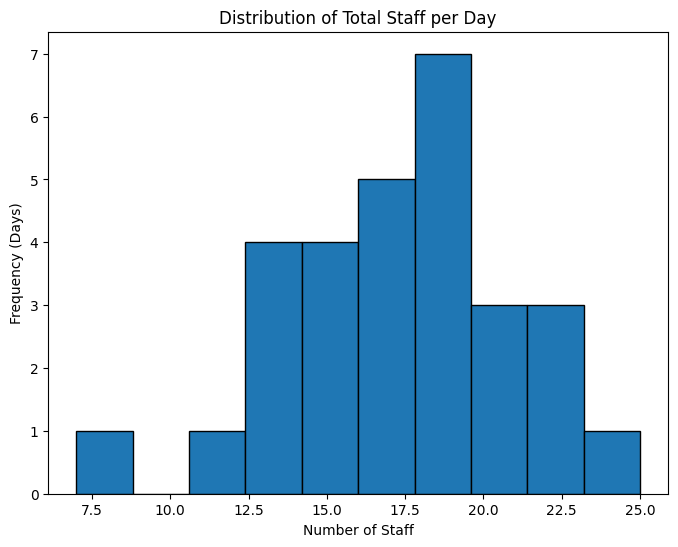

In [473]:
# Adding a total column which consists of all staff types summed per day
staff_pivot["Total_Staff"] = staff_pivot.sum(axis=1)

plt.figure(figsize=(8,6))
plt.hist(staff_pivot["Total_Staff"], bins=10, edgecolor="black")
plt.title("Distribution of Total Staff per Day")
plt.xlabel("Number of Staff")
plt.ylabel("Frequency (Days)")
plt.show()


This is the distribution of the number of staff in days, what can be seen from the chart is that the distribution is not uniform and there is need for further examination of staff allocation.

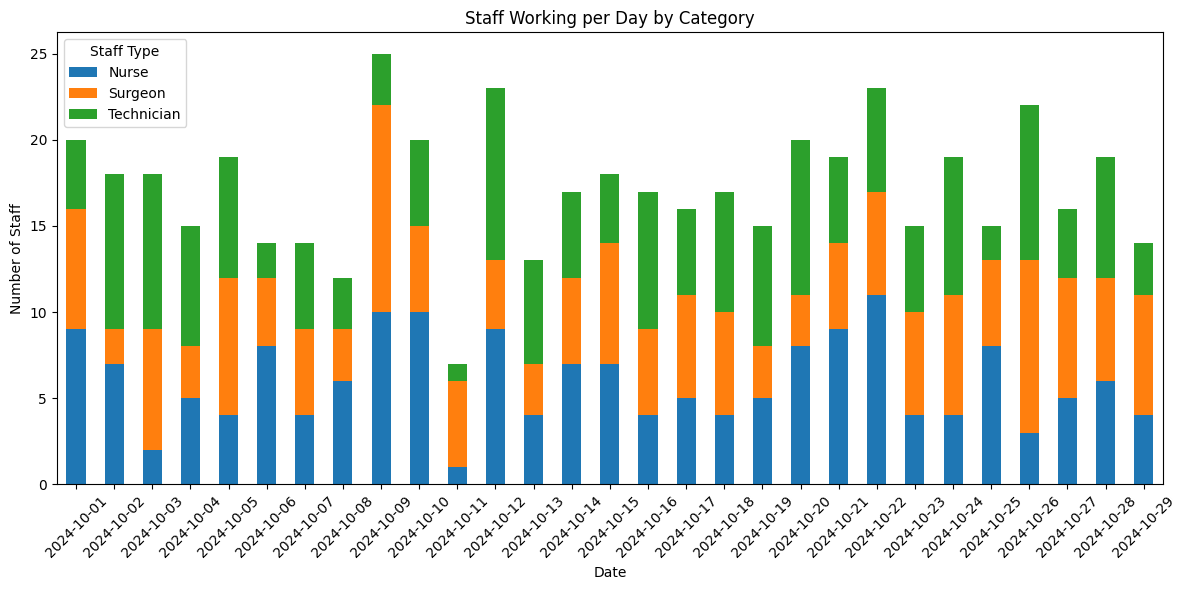

In [474]:
if "Total_Staff" in staff_pivot.columns:
    staff_pivot = staff_pivot.drop(columns=["Total_Staff"])

staff_pivot.plot(kind="bar", stacked=True, figsize=(12,6))

plt.title("Staff Working per Day by Category")
plt.xlabel("Date")
plt.ylabel("Number of Staff")
plt.legend(title="Staff Type")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



This chart presents data distribution of staff type for each day. It can be seen that the number quite differs between each day and there is not a standard number of staff included in daily work of the hospital. Still the chart doesn't answer all questions and data needs to be presented in better way.

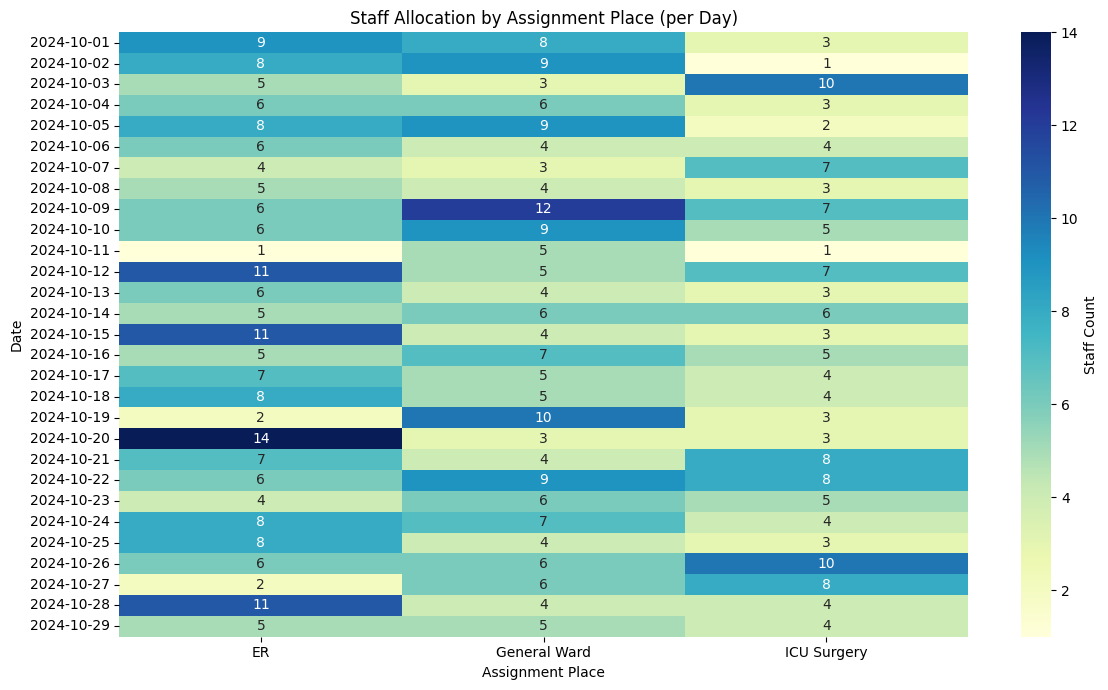

In [475]:
# Use the grouped data (day, assignment, staff count)
staff_matrix = (
    staff_df.groupby(["Shift_Day", "Current_Assignment"])["Staff_ID"]
    .nunique()
    .reset_index(name="Staff_Count")
)

# Making matrix pivot
staff_matrix_pivot = staff_matrix.pivot(
    index="Shift_Day", 
    columns="Current_Assignment", 
    values="Staff_Count"
).fillna(0)

plt.figure(figsize=(12,7))
sns.heatmap(
    staff_matrix_pivot, 
    annot=True, fmt=".0f", cmap="YlGnBu", cbar_kws={'label': 'Staff Count'}
)

plt.title("Staff Allocation by Assignment Place (per Day)")
plt.xlabel("Assignment Place")
plt.ylabel("Date")
plt.tight_layout()
plt.show()


The heatmap presents the spread of the staff between 3 major areas, as can be seen there is not fixed number for each of the department and the data can be seen quite random for instance the diffrence between 2 and 14 people working in ER just in one day or where there is only 1 person working in the department needs further examination.

That's why the next step is to prepare heatmap with distribution between different departments and roles of the staff members.

In [476]:
staff_df["Shift_Date"] = pd.to_datetime(staff_df["Shift_Date"], errors="coerce")
staff_df["Shift_Day"] = staff_df["Shift_Date"].dt.date

# Group by day, assignment place, and staff type
staff_matrix = (
    staff_df.groupby(["Shift_Day", "Current_Assignment", "Staff_Type"])["Staff_ID"]
    .nunique()
    .reset_index(name="Staff_Count")
)

staff_matrix_pivot = staff_matrix.pivot_table(
    index="Shift_Day",
    columns=["Current_Assignment", "Staff_Type"],
    values="Staff_Count",
    fill_value=0
).astype(int)

print("📋 Staff per Assignment and Staff Type (per Day):")
print(staff_matrix_pivot)


📋 Staff per Assignment and Staff Type (per Day):
Current_Assignment    ER                    General Ward                      
Staff_Type         Nurse Surgeon Technician        Nurse Surgeon Technician   
Shift_Day                                                                     
2024-10-01             4       3          2            3       3          2  \
2024-10-02             2       2          4            5       0          4   
2024-10-03             0       0          5            2       1          0   
2024-10-04             3       1          2            1       2          3   
2024-10-05             2       5          1            2       2          5   
2024-10-06             3       2          1            2       1          1   
2024-10-07             1       2          1            2       1          0   
2024-10-08             4       1          0            1       2          1   
2024-10-09             4       1          1            3       7          2   
202

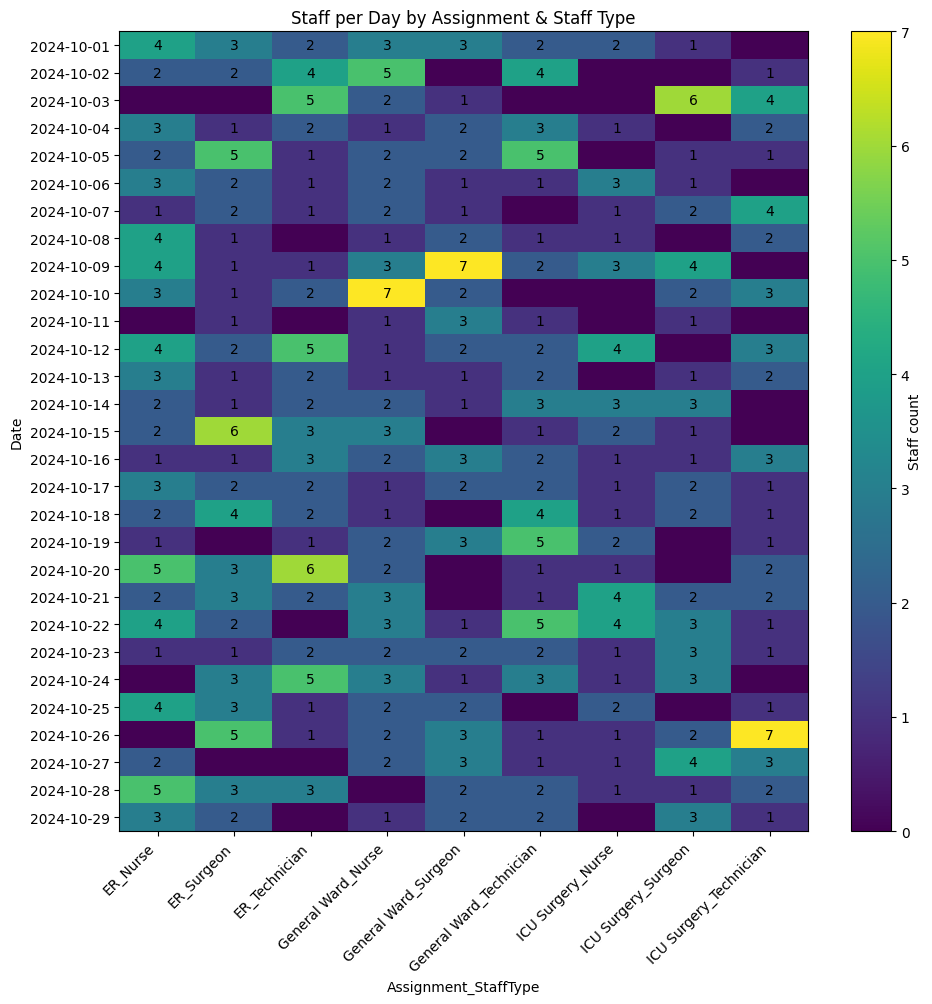

In [477]:
if isinstance(staff_matrix_pivot.columns, pd.MultiIndex):
    staff_matrix_plot = staff_matrix_pivot.copy()
    staff_matrix_plot.columns = [f"{a}_{b}" for a,b in staff_matrix_plot.columns]
else:
    staff_matrix_plot = staff_matrix_pivot.copy()


data = staff_matrix_plot.values.astype(float)
row_labels = staff_matrix_plot.index.astype(str).tolist()
col_labels = staff_matrix_plot.columns.tolist()

plt.figure(figsize=(max(10, len(col_labels)*0.5), max(6, len(row_labels)*0.35)))
im = plt.imshow(data, aspect="auto")  # no explicit colormap to keep defaults
cbar = plt.colorbar(im)
cbar.ax.set_ylabel("Staff count", rotation=90, va="center")

plt.xticks(ticks=np.arange(len(col_labels)), labels=col_labels, rotation=45, ha="right")
plt.yticks(ticks=np.arange(len(row_labels)), labels=row_labels)

plt.title("Staff per Day by Assignment & Staff Type")
plt.xlabel("Assignment_StaffType")
plt.ylabel("Date")
plt.tight_layout()

if data.size <= 2000:  
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            val = int(data[i, j])
            if val != 0:
                plt.text(j, i, str(val), ha="center", va="center")

plt.show()


The heatmap provides information of staff members available in each role and department. There are a lot days when the number of staff in category is 0. That provides further evidence that the data was generated for learning purposes and is not from real life scenario.

Next question to examine in data is how many patients were admitted to each of the departments in the hospital:

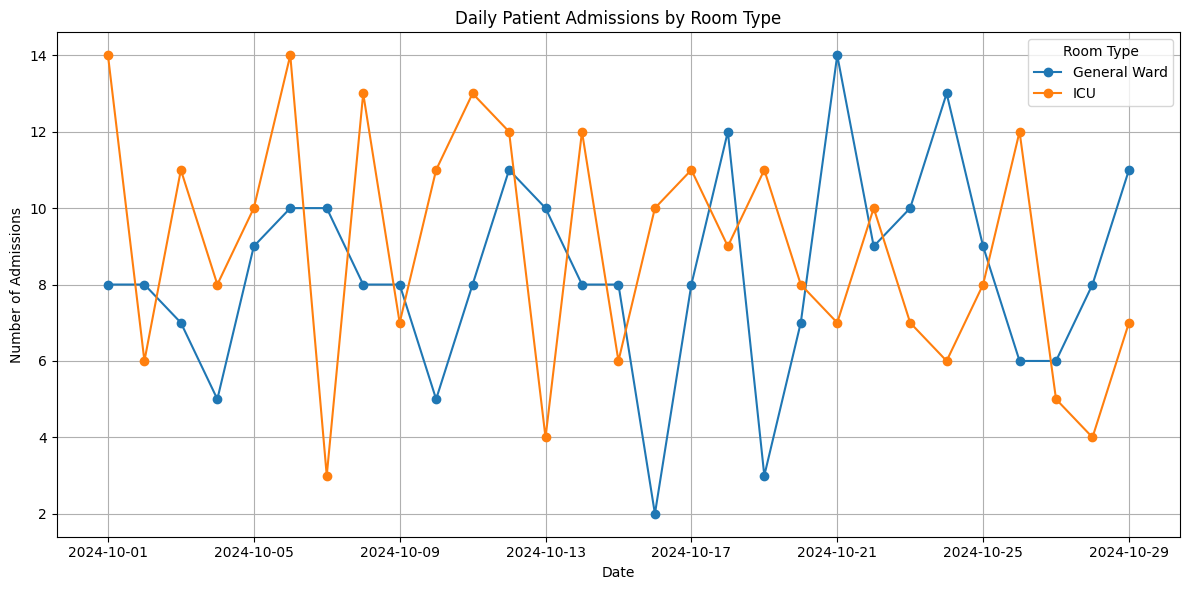

In [478]:
patient_df["Admission_Date"] = pd.to_datetime(patient_df["Admission_Date"], errors="coerce")

admissions_per_day_room = (
    patient_df.groupby([patient_df["Admission_Date"].dt.date, "Room_Type"])["Patient_ID"]
    .count()
    .reset_index()
)

admissions_pivot = admissions_per_day_room.pivot(
    index="Admission_Date", columns="Room_Type", values="Patient_ID"
).fillna(0)

admissions_pivot.plot(kind="line", marker="o", figsize=(12,6))

plt.title("Daily Patient Admissions by Room Type")
plt.xlabel("Date")
plt.ylabel("Number of Admissions")
plt.legend(title="Room Type")
plt.grid(True)
plt.tight_layout()
plt.show()


As can be seen, the patients were only admitted to General Ward and ICU, none of them were admitted to ER. whereas staff is working in 3 departments. Next step is to check what are the patient room types, and what departments they were admitted to

In [479]:
patient_room_types = patient_df["Room_Type"].unique().tolist()
print(patient_df["Room_Type"].value_counts())


Room_Type
ICU             259
General Ward    241
Name: count, dtype: int64


In [480]:
staff_assignments = staff_df["Current_Assignment"].unique().tolist()
print(staff_df["Current_Assignment"].value_counts())


Current_Assignment
ER              190
General Ward    172
ICU Surgery     138
Name: count, dtype: int64


As can be seen, zero patients were admitted to ER.

# Insights:

Based on previously presented evidence, including 40% of patient cases with discharge date before admission date and uneven spread of the staff and patients between departments, it can be concluded that data was probably generated. There are several ways to approach this challenge. In real life scenario, the solution will require redoing ecports of data from database to check if they are accurate.

For data analytics project the solution is to regenerate the data with adding additional requirements that will provide more real-time data, for instance ensuring that admitted date is before discharge data and in each department and role the number of staff is between certain range, which is more similar to real life situation.

In [481]:
def regenerate_staff_data(
    start_date="2024-10-01",
    end_date="2024-10-31",
    placements=("ER", "General Ward", "ICU"),
    role_ranges=None, 
    shifts=("Day", "Evening"), 
    seed=123
):
    """
    Returns a DataFrame with columns:
    Staff_ID,Staff_Type,Shift_Date,Shift_Start_Time,Shift_End_Time,
    Current_Assignment,Hours_Worked,Patients_Assigned,Overtime_Hours
    """
    if role_ranges is None:
        role_ranges = {
            "Nurse": (4, 6),
            "Surgeon": (2, 4),
            "Technician": (2, 4),
        }

    rng = np.random.default_rng(seed)
    days = pd.date_range(pd.to_datetime(start_date).normalize(),
                         pd.to_datetime(end_date).normalize(), freq="D")

    shift_templates = {
        "Day":     (time(8, 0),  time(16, 0),  8),
        "Evening": (time(16, 0), time(23, 0),  7),
        "Night":   (time(23, 0), time(7, 0),   8),  
    }

    patients_per_role = {
        "Nurse":      (3, 10),
        "Surgeon":    (1, 4),
        "Technician": (2, 6),
    }

    rows = []
    next_id = 1  

    for d in days:
        for place in placements:
            role_counts = {
                role: int(rng.integers(low, high + 1))
                for role, (low, high) in role_ranges.items()
            }

            # Splitting counts across shifts evenly
            for role, count in role_counts.items():
                if count == 0:
                    continue
                split_indices = np.array_split(np.arange(count), len(shifts))
                per_shift_counts = [len(x) for x in split_indices]

                for shift_name, n_staff in zip(shifts, per_shift_counts):
                    start_t, end_t, base_hours = shift_templates[shift_name]

                    for _ in range(n_staff):
                        staff_id = f"S{next_id:03d}"
                        next_id += 1

                        # Hours & overtime with small variation
                        hours = base_hours + int(rng.integers(-1, 2))  # +/-1
                        hours = max(6, min(12, hours))
                        overtime = max(0, hours - 8)

                        # Including differnt start/end minutes for realism
                        start_min_jitter = int(rng.integers(0, 30))
                        end_min_jitter   = int(rng.integers(0, 30))

                        # Build datetimes
                        shift_start_dt = datetime.combine(d.date(), start_t) + timedelta(minutes=start_min_jitter)
                        end_day = d if end_t > start_t else d + pd.Timedelta(days=1)
                        shift_end_dt = datetime.combine(end_day.date(), end_t) + timedelta(minutes=end_min_jitter)

                        # Patients assigned
                        p_lo, p_hi = patients_per_role.get(role, (1, 5))
                        patients_assigned = int(rng.integers(p_lo, p_hi + 1))

                        rows.append({
                            "Staff_ID": staff_id,
                            "Staff_Type": role,
                            "Shift_Date": shift_start_dt.strftime("%Y-%m-%d %H:%M:%S"),
                            "Shift_Start_Time": shift_start_dt.strftime("%I:%M %p"),
                            "Shift_End_Time": shift_end_dt.strftime("%I:%M %p"),
                            "Current_Assignment": place,
                            "Hours_Worked": hours,
                            "Patients_Assigned": patients_assigned,
                            "Overtime_Hours": overtime,
                        })

    df = pd.DataFrame(rows)

    # Ensuring exact column order
    cols = [
        "Staff_ID","Staff_Type","Shift_Date","Shift_Start_Time","Shift_End_Time",
        "Current_Assignment","Hours_Worked","Patients_Assigned","Overtime_Hours"
    ]
    df = df[cols]
    return df

staff_df_new = regenerate_staff_data(
    start_date="2024-10-01",
    end_date="2024-10-31",
    placements=("ER", "General Ward", "ICU"),
    role_ranges={"Nurse": (4,6), "Surgeon": (2,4), "Technician": (2,4)},
    shifts=("Day","Evening"),
    seed=123
)

print(staff_df_new.head())
print(staff_df_new.shape)
staff_df_new.to_csv("staff_regenerated.csv", index=False)


  Staff_ID Staff_Type           Shift_Date Shift_Start_Time Shift_End_Time   
0     S001      Nurse  2024-10-01 08:27:00         08:27 AM       04:06 PM  \
1     S002      Nurse  2024-10-01 08:10:00         08:10 AM       04:05 PM   
2     S003      Nurse  2024-10-01 16:13:00         04:13 PM       11:27 PM   
3     S004      Nurse  2024-10-01 16:23:00         04:23 PM       11:24 PM   
4     S005    Surgeon  2024-10-01 08:00:00         08:00 AM       04:15 PM   

  Current_Assignment  Hours_Worked  Patients_Assigned  Overtime_Hours  
0                 ER             7                  5               0  
1                 ER             7                  5               0  
2                 ER             8                  6               0  
3                 ER             6                  9               0  
4                 ER             9                  2               1  
(1037, 9)


Next step is checking the unique values from patient colums to use them in generating new patient data.

In [482]:
unique_dict = {
    "Primary_Diagnosis": patient_df["Primary_Diagnosis"].unique().tolist(),
    "Procedure_Performed": patient_df["Procedure_Performed"].unique().tolist(),
    "Room_Type": patient_df["Room_Type"].unique().tolist(),
    "Bed_Days": sorted(patient_df["Bed_Days"].unique().tolist()),
    "Supplies_Used": patient_df["Supplies_Used"].unique().tolist(),
    "Equipment_Used": patient_df["Equipment_Used"].unique().tolist(),
}

print("📋 Dictionary of unique values from dataset:")
for k, v in unique_dict.items():
    print(f"{k}: {v}")


📋 Dictionary of unique values from dataset:
Primary_Diagnosis: ['Diabetes', 'Fracture', 'Appendicitis', 'Pneumonia']
Procedure_Performed: ['Appendectomy', 'Chest X-ray', 'MRI', 'Blood Test']
Room_Type: ['General Ward', 'ICU']
Bed_Days: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
Supplies_Used: ['Gloves, IV', 'Gown, IV', 'Mask, Gown']
Equipment_Used: ['Surgical Table', 'MRI Machine', 'X-ray Machine']


Following, new patient data will be generated from dictionary prepared before. To ensure more realistic approach, there is set of rules defined in generated data:
1. Every diagnosis has allowed procedures that can follow
2. For each procedure, there is preferred equipment to use and staff to include
3. Depending on number of days there is established probability where patient can stay, taking about that short stays mostly fall under ER category

In [483]:
def generate_patient_data(
    n_patients: int = 500,
    start_date: str = "2024-10-01",
    end_date: str = "2024-10-31",
    seed: int = 42,
    outfile: str = "patients_generated.csv",
):
    rng = np.random.default_rng(seed)

    diagnoses = ['Pneumonia', 'Appendicitis', 'Fracture', 'Diabetes']
    procedures = ['MRI', 'Chest X-ray', 'Blood Test', 'Appendectomy']
    room_types = ['General Ward', 'ICU', 'ER']
    bed_days_allowed = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
    supplies_options = ['Mask, Gown', 'Gloves, IV', 'Gown, IV']
    equipment_options = ['MRI Machine', 'Surgical Table', 'X-ray Machine']

    # Diagnosis -> allowed procedures
    diag_to_procs = {
        'Pneumonia':     ['Chest X-ray', 'Blood Test'],
        'Appendicitis':  ['Appendectomy'],
        'Fracture':      ['Chest X-ray', 'MRI'],
        'Diabetes':      ['Blood Test'],
    }

    # Procedure -> preferred equipment
    preferred_equipment = {
        'MRI':          'MRI Machine',
        'Chest X-ray':  'X-ray Machine',
        'Appendectomy': 'Surgical Table',
    }

    # Procedure -> staff ranges
    staff_by_procedure = {
        'MRI':          ((1, 2), (0, 1), (1, 2)),
        'Chest X-ray':  ((0, 1), (0, 1), (1, 2)),
        'Blood Test':   ((1, 2), (0, 0), (0, 1)),
        'Appendectomy': ((1, 3), (1, 2), (0, 1)),
    }

    start_dt = pd.to_datetime(start_date)
    end_dt = pd.to_datetime(end_date)
    if end_dt < start_dt:
        raise ValueError("end_date must be on/after start_date")

    rows = []
    for i in range(1, n_patients + 1):
        # Admission date
        day_offset = int(rng.integers(0, (end_dt - start_dt).days + 1))
        admission_dt = start_dt + pd.to_timedelta(day_offset, unit="D")
        admission_dt += pd.to_timedelta(int(rng.integers(0, 24 * 3600)), unit="s")

        #Picking values from dictionaries 
        diag = rng.choice(diagnoses)
        allowed_procs = diag_to_procs.get(diag, procedures)
        proc = rng.choice(allowed_procs)

        bed_days = int(rng.choice(bed_days_allowed))

        # Room selection rule
        # ER is allowed ONLY when stay is strictly less than 2 days.
        # If bed_days < 2 -> allow ER (likely), else exclude ER.
        if bed_days < 2:
            room = rng.choice(['ER', 'General Ward', 'ICU'], p=[0.7, 0.2, 0.1])
        else:
            # Longer stays: choose between General Ward and ICU.
            # ICU more likely if surgical or very long stay.
            if proc == 'Appendectomy' or bed_days >= 10:
                room = rng.choice(['ICU', 'General Ward'], p=[0.75, 0.25])
            else:
                room = rng.choice(['General Ward', 'ICU'], p=[0.8, 0.2])

        supplies = rng.choice(supplies_options)

        # Equipment preference (fall back to any allowed to stay within your list)
        equip = preferred_equipment.get(proc)
        if equip not in equipment_options:
            equip = rng.choice(equipment_options)

        # Staff needed split into three integer columns 
        (nurse_rng, doc_rng, tech_rng) = staff_by_procedure[proc]
        nurses = int(rng.integers(nurse_rng[0], nurse_rng[1] + 1))
        doctors = int(rng.integers(doc_rng[0], doc_rng[1] + 1))
        technicians = int(rng.integers(tech_rng[0], tech_rng[1] + 1))

        # Discharge after admission
        discharge_dt = admission_dt + timedelta(days=bed_days, hours=int(rng.integers(0, 12)))
        if discharge_dt <= admission_dt:
            discharge_dt = admission_dt + timedelta(days=1)

        rows.append({
            "Patient_ID": f"P{i:03d}",
            "Admission_Date": admission_dt.strftime("%Y-%m-%d %H:%M:%S"),
            "Discharge_Date": discharge_dt.strftime("%Y-%m-%d %H:%M:%S"),
            "Primary_Diagnosis": diag,
            "Procedure_Performed": proc,
            "Room_Type": room,
            "Bed_Days": bed_days,
            "Supplies_Used": supplies,
            "Equipment_Used": equip,
            "Nurses_Needed": nurses,
            "Doctors_Needed": doctors,
            "Technicians_Needed": technicians,
        })

    df = pd.DataFrame(rows)

    cols = [
        "Patient_ID", "Admission_Date", "Discharge_Date",
        "Primary_Diagnosis", "Procedure_Performed", "Room_Type",
        "Bed_Days", "Supplies_Used", "Equipment_Used",
        "Nurses_Needed", "Doctors_Needed", "Technicians_Needed"
    ]
    df = df[cols]

    df.to_csv(outfile, index=False)
    print(f"Generated {len(df)} patient records → {outfile}")


generate_patient_data(
    n_patients=500,
    start_date="2024-10-01",
    end_date="2024-10-31",
    seed=123,
    outfile="patients_generated.csv",
    )


Generated 500 patient records → patients_generated.csv


Created data will now be loaded and analysed:

In [484]:
staff_new_df = pd.read_csv("staff_regenerated.csv")
for col in staff_new_df.columns:
    if "date" in col.lower():
        staff_new_df[col] = pd.to_datetime(staff_new_df[col], errors="coerce")

if "Shift_Date" not in staff_new_df.columns:
    raise KeyError("Column 'Shift_Date' not found in staff_regenerated.csv")

staff_new_df["Shift_Day"] = staff_new_df["Shift_Date"].dt.date 

In [485]:
staff_new_df["Shift_Date"] = pd.to_datetime(staff_new_df["Shift_Date"], errors="coerce")
staff_new_df["Shift_Day"] = staff_new_df["Shift_Date"].dt.date

staff_new_matrix = (
    staff_new_df.groupby(["Shift_Day", "Current_Assignment", "Staff_Type"])["Staff_ID"]
    .nunique()
    .reset_index(name="Staff_Count")
)

staff_new_matrix_pivot = staff_new_matrix.pivot_table(
    index="Shift_Day",
    columns=["Current_Assignment", "Staff_Type"],
    values="Staff_Count",
    fill_value=0
).astype(int)

print("Staff per Assignment and Staff Type (per Day):")
print(staff_new_matrix_pivot)


Staff per Assignment and Staff Type (per Day):
Current_Assignment    ER                    General Ward                      
Staff_Type         Nurse Surgeon Technician        Nurse Surgeon Technician   
Shift_Day                                                                     
2024-10-01             4       4          3            5       3          2  \
2024-10-02             6       3          3            5       2          2   
2024-10-03             5       4          2            6       4          4   
2024-10-04             6       4          3            4       3          3   
2024-10-05             4       4          4            5       2          3   
2024-10-06             6       4          4            6       4          4   
2024-10-07             4       2          2            5       4          4   
2024-10-08             5       4          3            5       4          2   
2024-10-09             5       4          2            5       3          3   
2024-

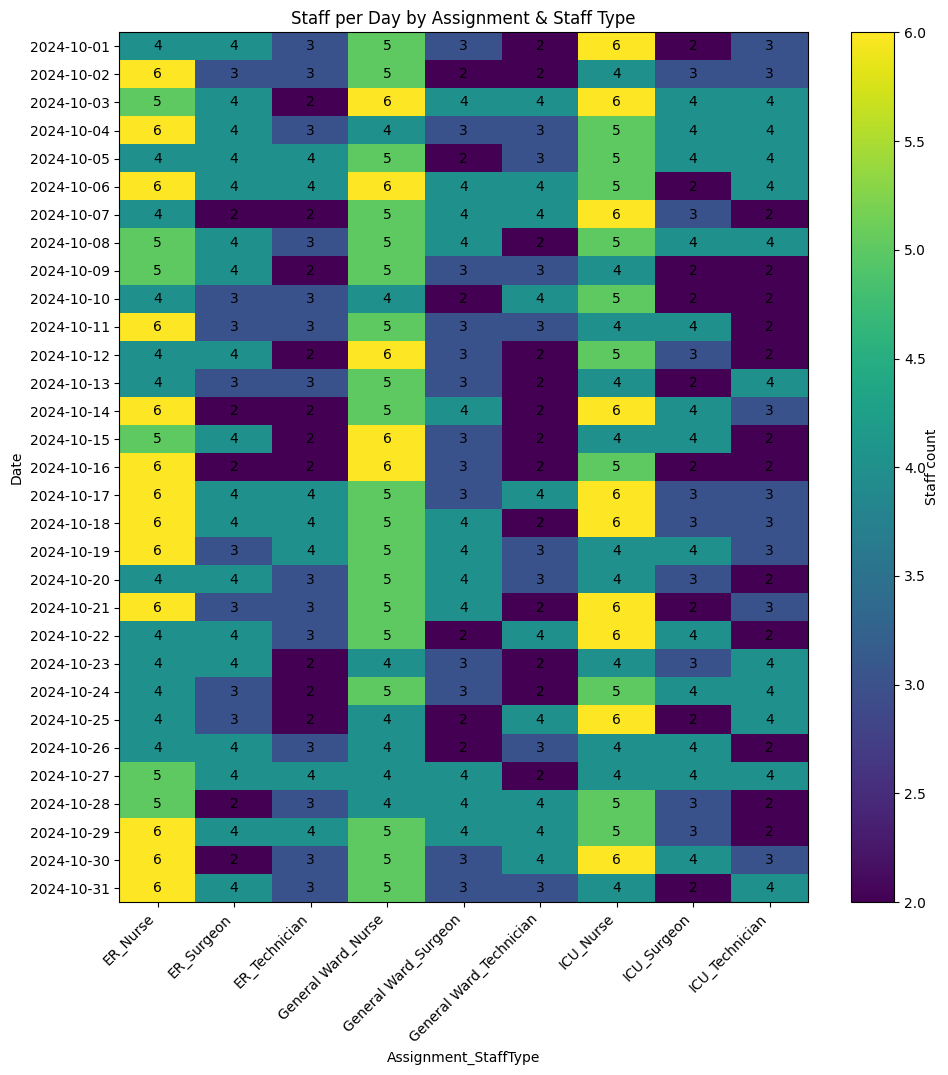

In [486]:
if isinstance(staff_new_matrix_pivot.columns, pd.MultiIndex):
    staff_new_matrix_plot = staff_new_matrix_pivot.copy()
    staff_new_matrix_plot.columns = [f"{a}_{b}" for a,b in staff_new_matrix_plot.columns]
else:
    staff_new_matrix_plot = staff_new_matrix_pivot.copy()


data = staff_new_matrix_plot.values.astype(float)
row_labels = staff_new_matrix_plot.index.astype(str).tolist()
col_labels = staff_new_matrix_plot.columns.tolist()

plt.figure(figsize=(max(10, len(col_labels)*0.5), max(6, len(row_labels)*0.35)))
im = plt.imshow(data, aspect="auto")  
cbar = plt.colorbar(im)
cbar.ax.set_ylabel("Staff count", rotation=90, va="center")

plt.xticks(ticks=np.arange(len(col_labels)), labels=col_labels, rotation=45, ha="right")
plt.yticks(ticks=np.arange(len(row_labels)), labels=row_labels)

plt.title("Staff per Day by Assignment & Staff Type")
plt.xlabel("Assignment_StaffType")
plt.ylabel("Date")
plt.tight_layout()

if data.size <= 2000: 
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            val = int(data[i, j])
            if val != 0:
                plt.text(j, i, str(val), ha="center", va="center")

plt.show()


The heatmap showcases the spread of the staff across different roles at the departments. As can be seen the spread between values is more realistic as in each day in every department there is enough number of staff to take care of patients.

Another performed check is checking the distribution of the number of patients for each day, the counting will be performed in folllowing way:

1. Admissions are count(+1) on the admission day.
2. Discharges are count as -1 on the day after the discharge date so the patient is still counted on their discharge day.
3. The baseline for patients already admitted before the month start and still in on the first day.
4. Cumulative sum of these daily changes gives the census per day.

Daily inpatient census:
2024-10-01     18
2024-10-02     28
2024-10-03     44
2024-10-04     48
2024-10-05     71
2024-10-06     89
2024-10-07     97
2024-10-08    106
2024-10-09    116
2024-10-10    123
2024-10-11    131
2024-10-12    126
2024-10-13    138
2024-10-14    137
2024-10-15    142
2024-10-16    150
2024-10-17    147
2024-10-18    147
2024-10-19    136
2024-10-20    134
2024-10-21    132
2024-10-22    131
2024-10-23    141
2024-10-24    152
2024-10-25    139
2024-10-26    143
2024-10-27    148
2024-10-28    152
2024-10-29    141
2024-10-30    141
2024-10-31    136
Freq: D, dtype: int64


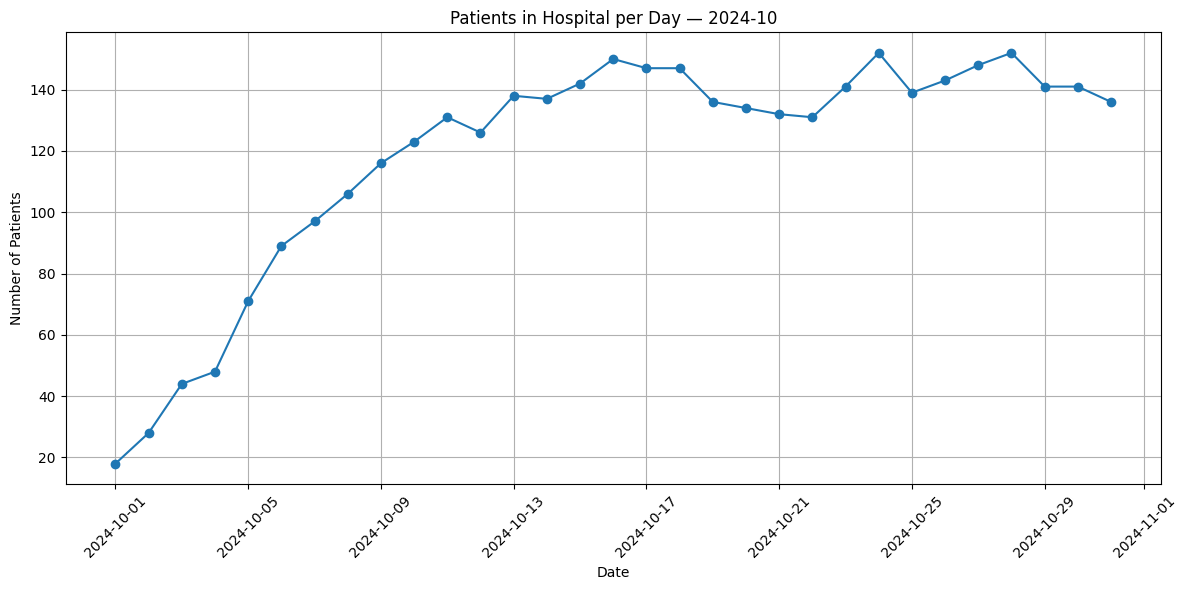

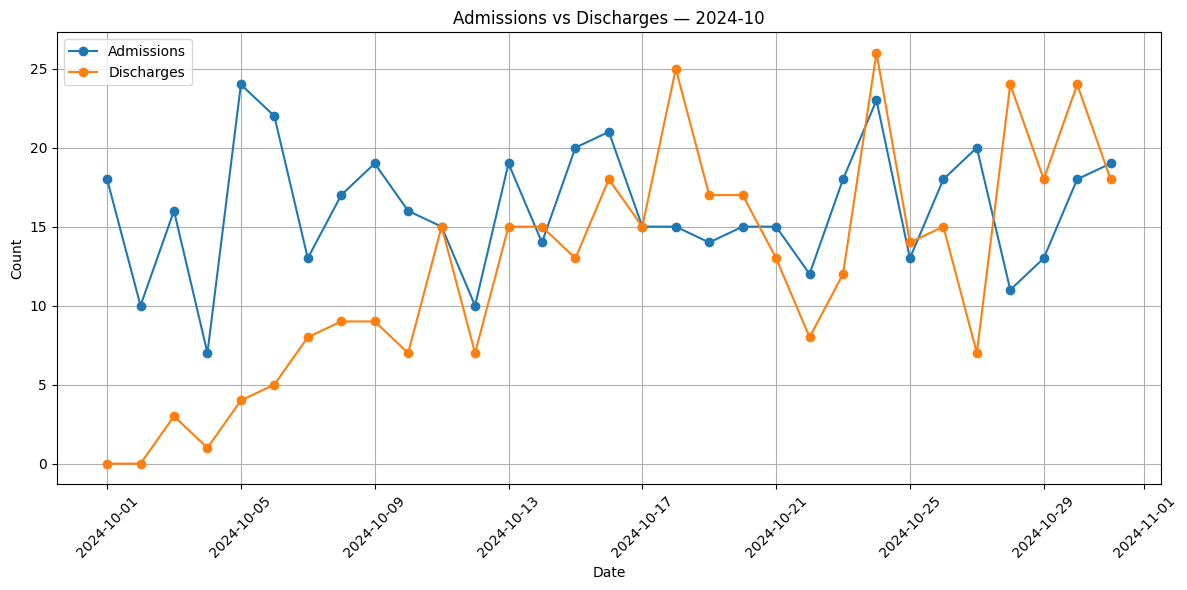

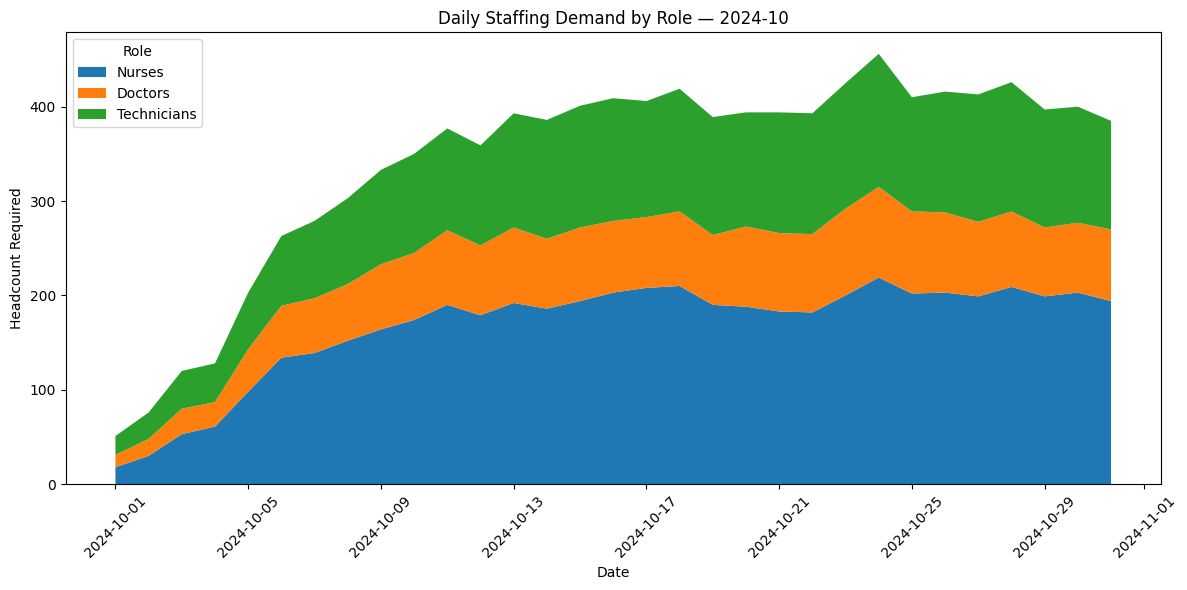

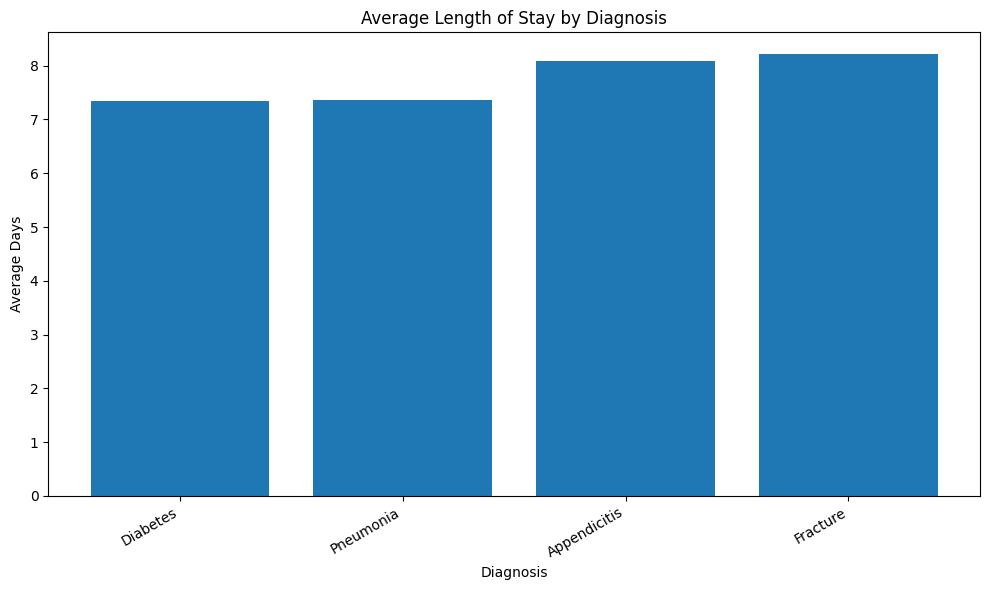

In [487]:
CSV_FILE = "patients_generated.csv"        
MONTH = "2024-10"               

patient_new_df = pd.read_csv(CSV_FILE, parse_dates=["Admission_Date", "Discharge_Date"])

patient_new_df = patient_new_df[patient_new_df["Admission_Date"] < patient_new_df["Discharge_Date"]].copy()

month_start = pd.to_datetime(f"{MONTH}-01")
month_end = (month_start + pd.offsets.MonthEnd(1)) 
days = pd.date_range(month_start, month_end, freq="D")

in_before = patient_new_df["Admission_Date"] < month_start
out_after_or_inmonth = patient_new_df["Discharge_Date"] >= month_start
baseline = patient_new_df[in_before & out_after_or_inmonth].shape[0]

admit_events = (
    patient_new_df.loc[patient_new_df["Admission_Date"].dt.date >= month_start.date(), "Admission_Date"]
      .dt.normalize()
      .value_counts()
      .sort_index()
)

discharge_events = (
    (patient_new_df["Discharge_Date"].dt.normalize() + pd.Timedelta(days=1))
      .value_counts()
      .sort_index()
)

events_index = pd.date_range(month_start, month_end + pd.Timedelta(days=1), freq="D")
admit_series = admit_events.reindex(events_index, fill_value=0)
discharge_series = discharge_events.reindex(events_index, fill_value=0)

delta = admit_series.sub(discharge_series, fill_value=0)

census_full = pd.Series(baseline, index=events_index).add(delta.cumsum(), fill_value=0)
census = census_full.reindex(days).fillna(method="ffill").astype(int)

print("Daily inpatient census:")
print(census)

plt.figure(figsize=(12, 6))
plt.plot(census.index, census.values, marker="o")
plt.title(f"Patients in Hospital per Day — {MONTH}")
plt.xlabel("Date")
plt.ylabel("Number of Patients")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


do_room_type_chart = True
if do_room_type_chart and "Room_Type" in df.columns:
    room_types = sorted(patient_new_df["Room_Type"].dropna().unique().tolist())
    room_census = pd.DataFrame(0, index=days, columns=room_types)

    for room in room_types:
        sub = patient_new_df[patient_new_df["Room_Type"] == room]

        base = ((sub["Admission_Date"] < month_start) & (sub["Discharge_Date"] >= month_start)).sum()

        adm = (
            sub.loc[sub["Admission_Date"].dt.date >= month_start.date(), "Admission_Date"]
               .dt.normalize()
               .value_counts()
               .sort_index()
        )
        dis = (
            (sub["Discharge_Date"].dt.normalize() + pd.Timedelta(days=1))
               .value_counts()
               .sort_index()
        )

        idx = pd.date_range(month_start, month_end + pd.Timedelta(days=1), freq="D")
        adm = adm.reindex(idx, fill_value=0)
        dis = dis.reindex(idx, fill_value=0)
        dlt = adm.sub(dis, fill_value=0)
        cens_full = pd.Series(base, index=idx).add(dlt.cumsum(), fill_value=0)
        room_census[room] = cens_full.reindex(days).fillna(method="ffill").astype(int)

    plt.figure(figsize=(12, 6))
    plt.stackplot(room_census.index, [room_census[c] for c in room_census.columns], labels=room_census.columns)
    plt.title(f"Patients in Hospital per Day by Room Type — {MONTH}")
    plt.xlabel("Date")
    plt.ylabel("Number of Patients")
    plt.xticks(rotation=45)
    plt.legend(title="Room Type", loc="upper left")
    plt.tight_layout()
    plt.show()

#Admissions vs Discharges / day
admissions = patient_new_df["Admission_Date"].dt.normalize().value_counts().reindex(days, fill_value=0)
discharges = patient_new_df["Discharge_Date"].dt.normalize().value_counts().reindex(days, fill_value=0)

plt.figure(figsize=(12, 6))
plt.plot(admissions.index, admissions.values, marker="o", label="Admissions")
plt.plot(discharges.index, discharges.values, marker="o", label="Discharges")
plt.title(f"Admissions vs Discharges — {MONTH}")
plt.xlabel("Date")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Daily staffing demand by role (stacked area)
def weighted_daily_series(patient_new_df, col, month_start, month_end):
    idx_full = pd.date_range(month_start, month_end + pd.Timedelta(days=1), freq="D")
    days_in_month = pd.date_range(month_start, month_end, freq="D")

    base = patient_new_df.loc[(patient_new_df["Admission_Date"] < month_start) & (patient_new_df["Discharge_Date"] >= month_start), col].sum()

    inc = (patient_new_df.loc[patient_new_df["Admission_Date"] >= month_start]
             .assign(day=patient_new_df["Admission_Date"].dt.normalize())
             .groupby("day")[col].sum()
             .reindex(idx_full, fill_value=0))

    dec = (patient_new_df.assign(day=(patient_new_df["Discharge_Date"].dt.normalize() + pd.Timedelta(days=1)))
             .groupby("day")[col].sum()
             .reindex(idx_full, fill_value=0))

    delta = inc.sub(dec, fill_value=0)
    full = pd.Series(base, index=idx_full) + delta.cumsum()
    return full.reindex(days_in_month).ffill().astype(int)

nurses_daily = weighted_daily_series(patient_new_df, "Nurses_Needed", month_start, month_end)
doctors_daily = weighted_daily_series(patient_new_df, "Doctors_Needed", month_start, month_end)
techs_daily   = weighted_daily_series(patient_new_df, "Technicians_Needed", month_start, month_end)

staff_daily = pd.DataFrame({
    "Nurses": nurses_daily,
    "Doctors": doctors_daily,
    "Technicians": techs_daily
})

plt.figure(figsize=(12, 6))
plt.stackplot(staff_daily.index, [staff_daily[c] for c in staff_daily.columns], labels=staff_daily.columns)
plt.title(f"Daily Staffing Demand by Role — {MONTH}")
plt.xlabel("Date")
plt.ylabel("Headcount Required")
plt.xticks(rotation=45)
plt.legend(title="Role", loc="upper left")
plt.tight_layout()
plt.show()

# Average Length of Stay (LOS) by Diagnosis
los_days = (patient_new_df["Discharge_Date"] - patient_new_df["Admission_Date"]).dt.total_seconds() / (24*3600)
los_by_dx = pd.Series(los_days.values, index=patient_new_df["Primary_Diagnosis"]).groupby(level=0).mean().sort_values()

plt.figure(figsize=(10, 6))
plt.bar(los_by_dx.index, los_by_dx.values)
plt.title("Average Length of Stay by Diagnosis")
plt.xlabel("Diagnosis")
plt.ylabel("Average Days")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

As can be seen, because the data is only for one month and it doesn't include data from previous month the number of patients is considerably smaller in the first days of the month, but then it rises steadily, which also implifies numbers of admissions and discharges and staff needed to help the patients.

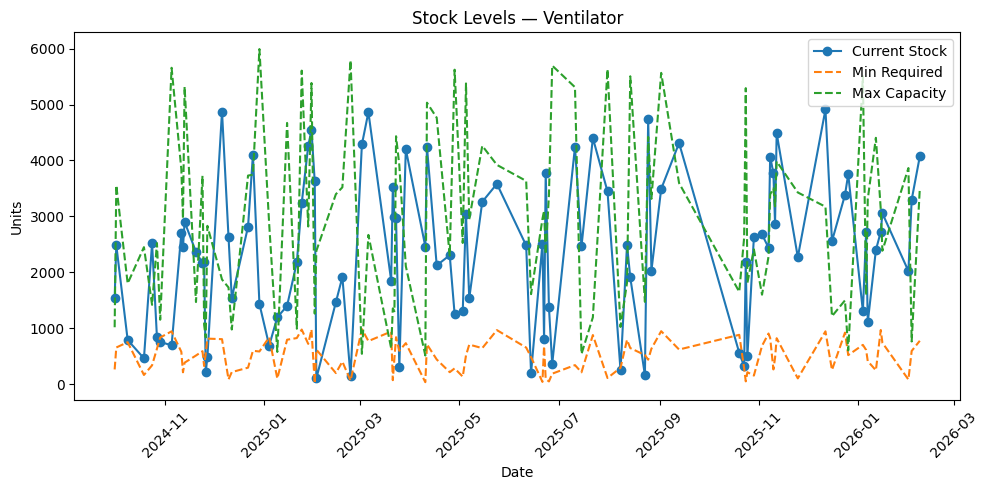

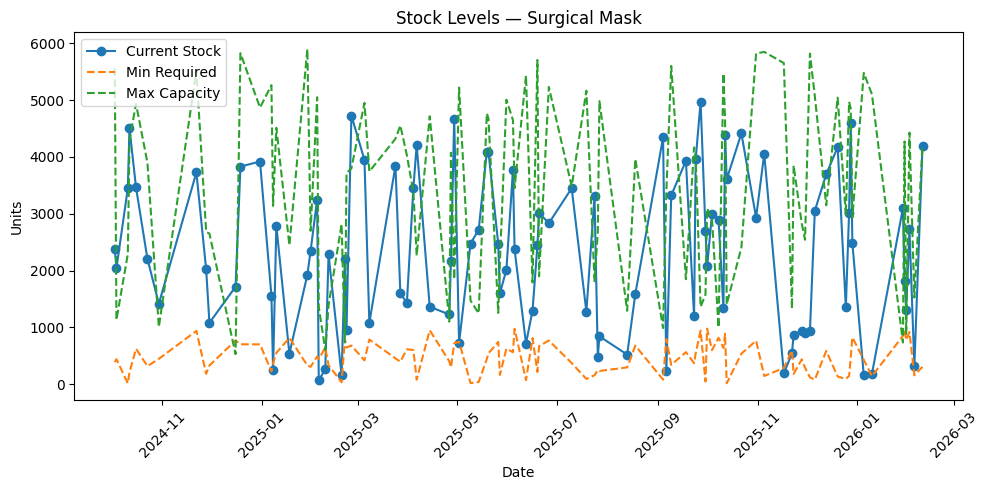

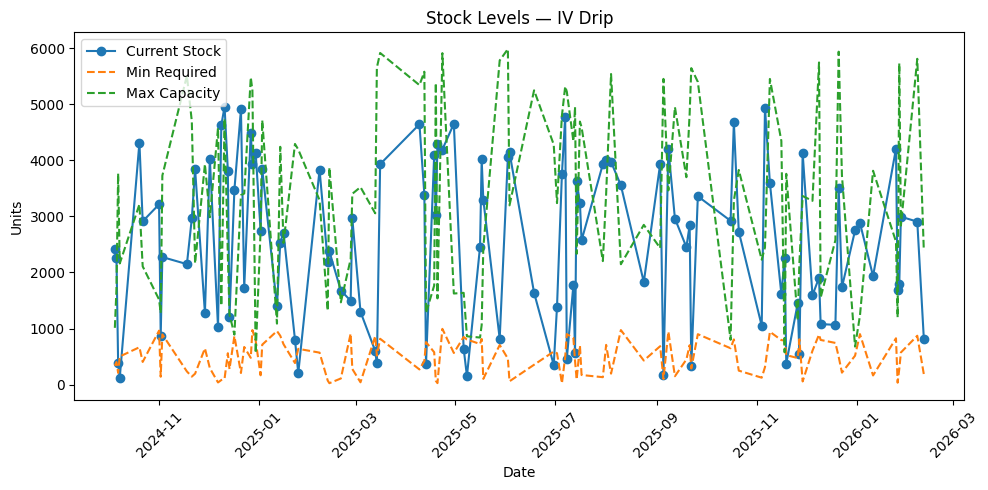

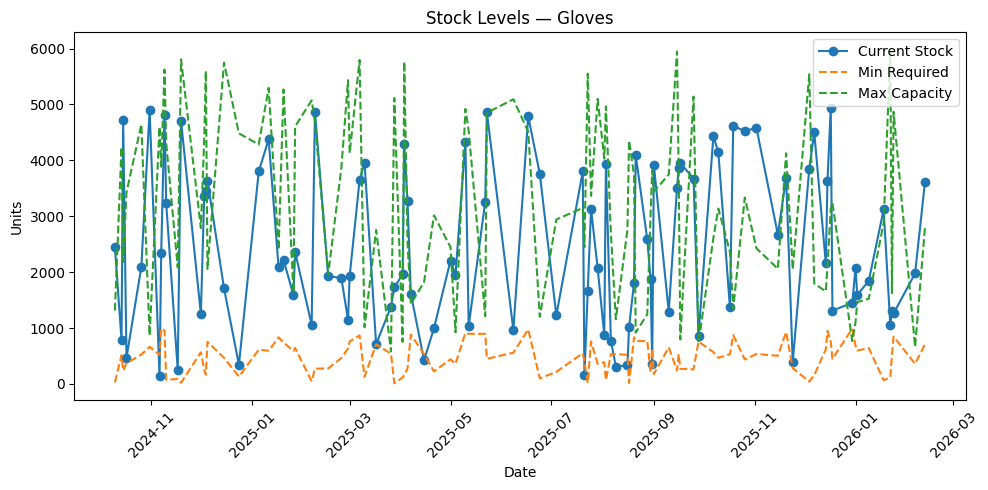

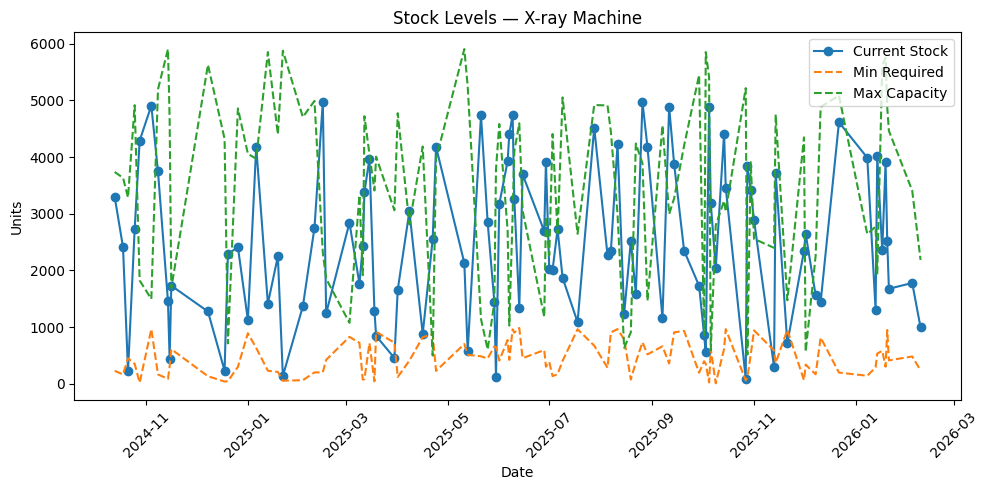

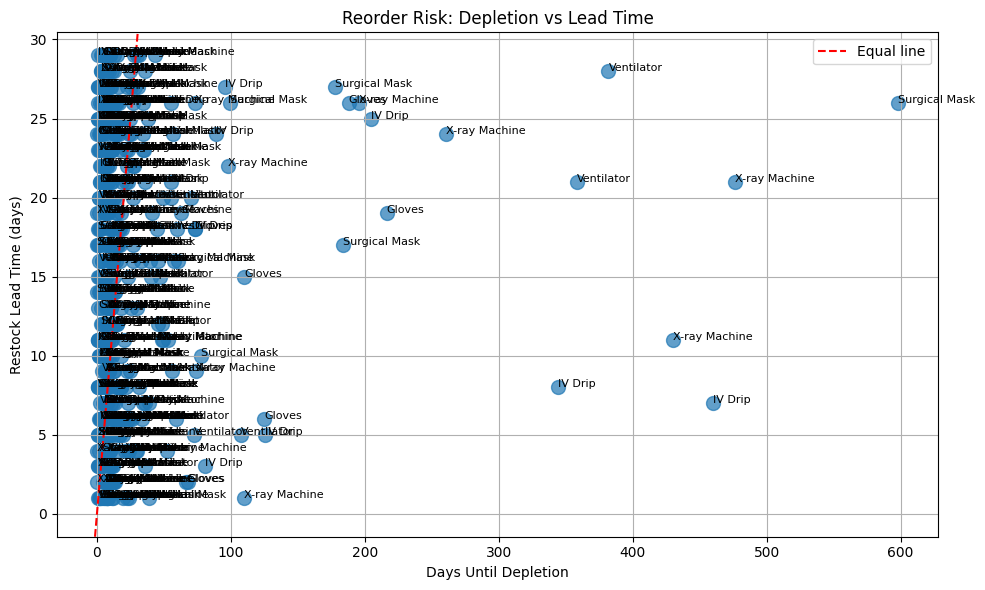

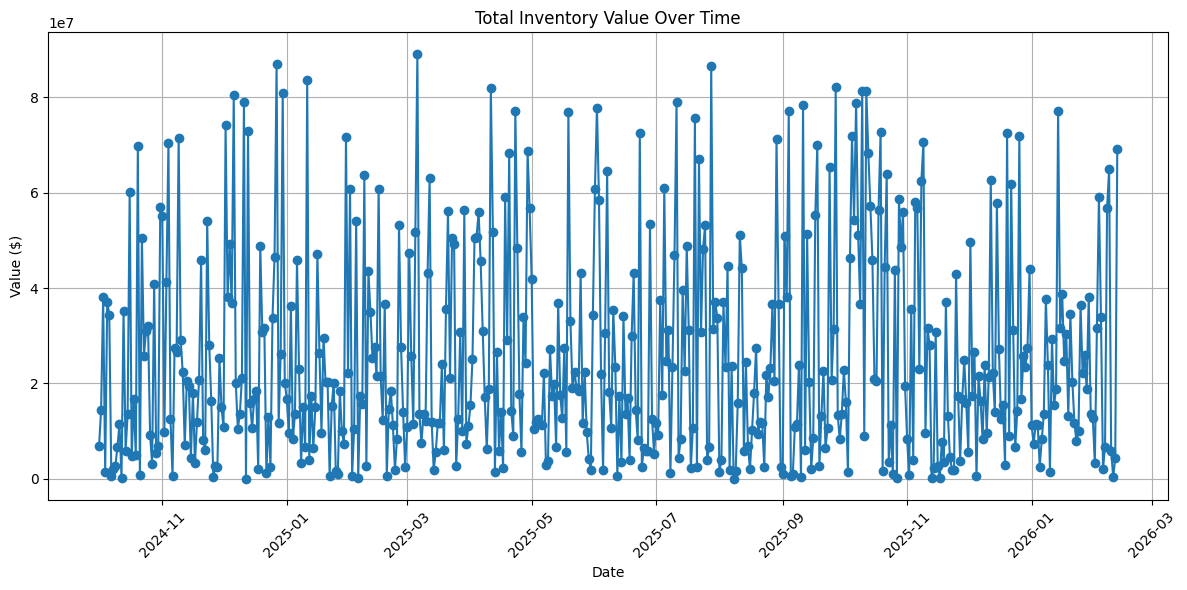

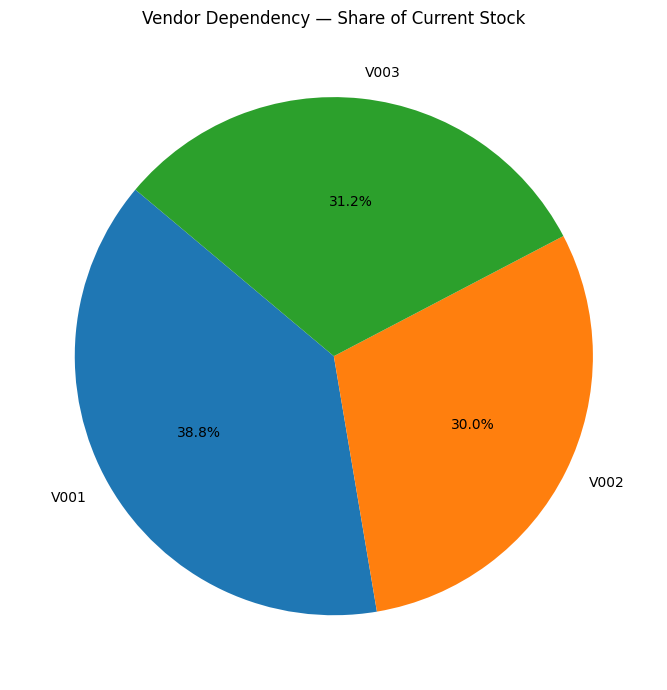

In [488]:
inventory_df["Unit_Cost"] = pd.to_numeric(inventory_df["Unit_Cost"], errors="coerce")
inventory_df["Current_Stock"] = pd.to_numeric(inventory_df["Current_Stock"], errors="coerce")
inventory_df["Avg_Usage_Per_Day"] = pd.to_numeric(inventory_df["Avg_Usage_Per_Day"], errors="coerce")
inventory_df["Restock_Lead_Time"] = pd.to_numeric(inventory_df["Restock_Lead_Time"], errors="coerce")

# 1) Stock vs Min/Max thresholds
items = inventory_df["Item_Name"].unique()
for item in items:
    sub = inventory_df[inventory_df["Item_Name"] == item].sort_values("Date")

    plt.figure(figsize=(10,5))
    plt.plot(sub["Date"], sub["Current_Stock"], marker="o", label="Current Stock")
    plt.plot(sub["Date"], sub["Min_Required"], linestyle="--", label="Min Required")
    plt.plot(sub["Date"], sub["Max_Capacity"], linestyle="--", label="Max Capacity")
    plt.title(f"Stock Levels — {item}")
    plt.xlabel("Date")
    plt.ylabel("Units")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Reorder Risk Forecast
inventory_df["Days_To_Depletion"] = inventory_df["Current_Stock"] / inventory_df["Avg_Usage_Per_Day"]
risk = inventory_df[["Item_Name","Days_To_Depletion","Restock_Lead_Time"]]

plt.figure(figsize=(10,6))
plt.scatter(risk["Days_To_Depletion"], risk["Restock_Lead_Time"], s=100, alpha=0.7)
for _, row in risk.iterrows():
    plt.text(row["Days_To_Depletion"], row["Restock_Lead_Time"], row["Item_Name"], fontsize=8)
plt.axline((0,0), slope=1, color="red", linestyle="--", label="Equal line")
plt.xlabel("Days Until Depletion")
plt.ylabel("Restock Lead Time (days)")
plt.title("Reorder Risk: Depletion vs Lead Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Inventory Value Trend
inventory_df["Inventory_Value"] = inventory_df["Current_Stock"] * inventory_df["Unit_Cost"]
value_trend = inventory_df.groupby("Date")["Inventory_Value"].sum()

plt.figure(figsize=(12,6))
plt.plot(value_trend.index, value_trend.values, marker="o")
plt.title("Total Inventory Value Over Time")
plt.xlabel("Date")
plt.ylabel("Value ($)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Vendor Dependency (pie)
vendor_share = inventory_df.groupby("Vendor_ID")["Current_Stock"].sum()

plt.figure(figsize=(7,7))
plt.pie(vendor_share, labels=vendor_share.index, autopct="%1.1f%%", startangle=140)
plt.title("Vendor Dependency — Share of Current Stock")
plt.tight_layout()
plt.show()


The stock available in the hospital in this dataset is 4 different categories of products which are supplied by 3 suppliers. There are days in the data when the current stock is not between minimal and maximum capacity for the product.

Let's examine hospital expenses further.

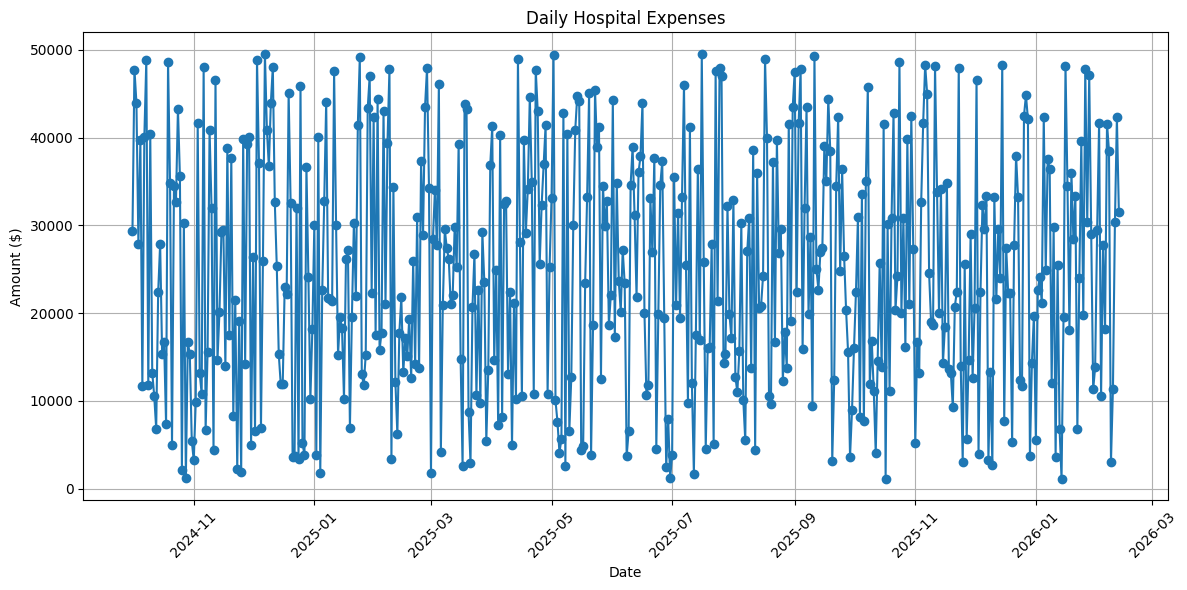

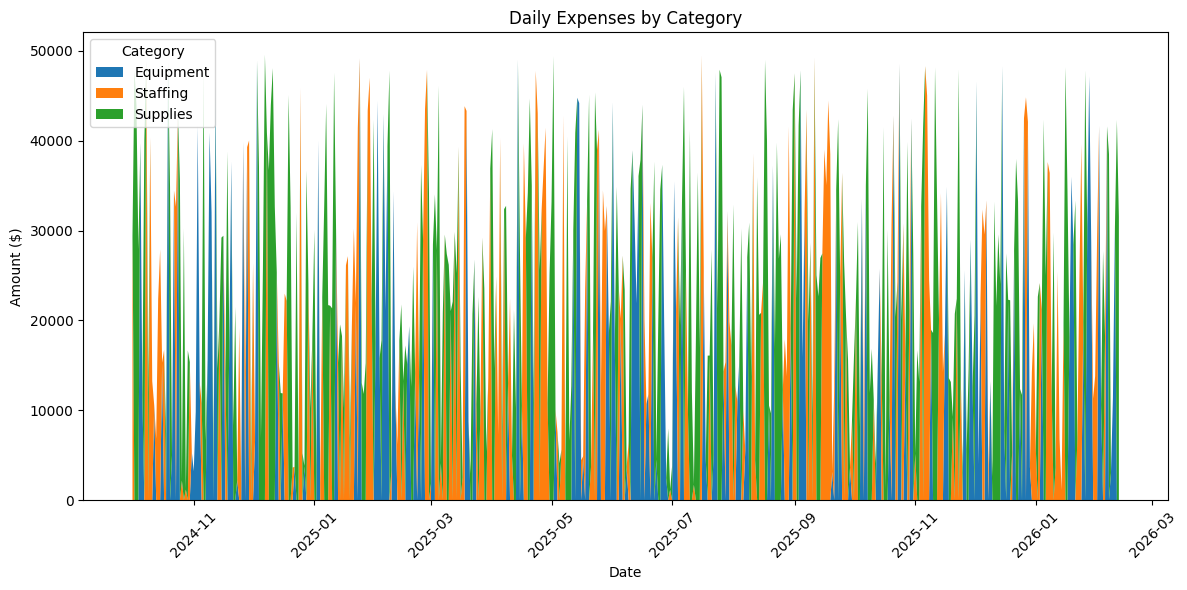

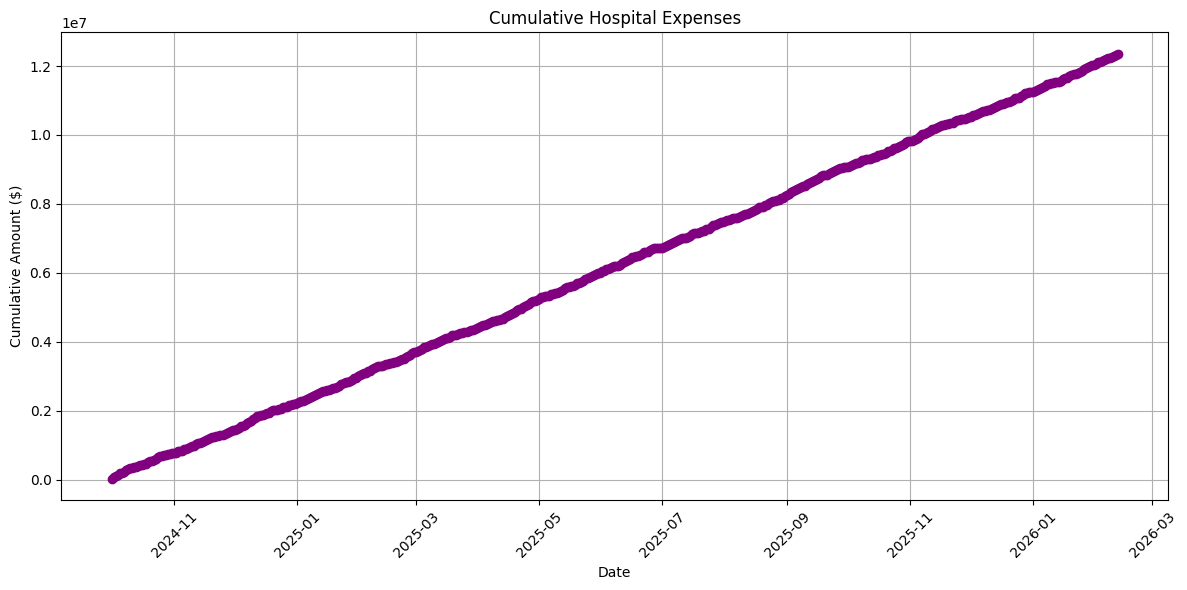

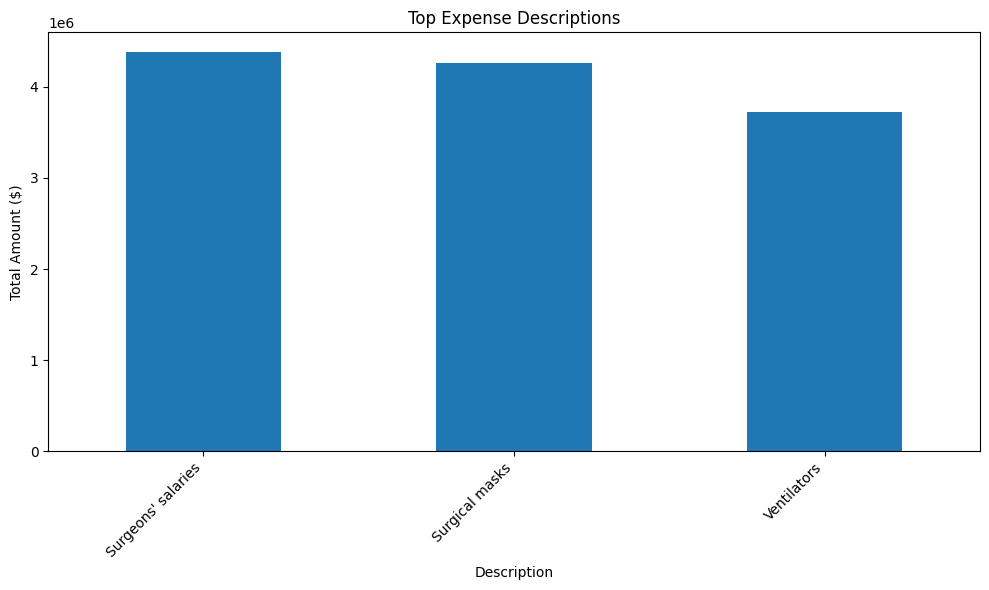

In [489]:
financial_df["Amount"] = pd.to_numeric(financial_df["Amount"], errors="coerce")

# Daily Expense Trend
daily_expenses = financial_df.groupby("Date")["Amount"].sum()

plt.figure(figsize=(12,6))
plt.plot(daily_expenses.index, daily_expenses.values, marker="o")
plt.title("Daily Hospital Expenses")
plt.xlabel("Date")
plt.ylabel("Amount ($)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Expenses by Category (stacked area)
cat_daily = financial_df.groupby(["Date","Expense_Category"])["Amount"].sum().unstack(fill_value=0)

plt.figure(figsize=(12,6))
plt.stackplot(cat_daily.index, [cat_daily[c] for c in cat_daily.columns], labels=cat_daily.columns)
plt.title("Daily Expenses by Category")
plt.xlabel("Date")
plt.ylabel("Amount ($)")
plt.xticks(rotation=45)
plt.legend(title="Category", loc="upper left")
plt.tight_layout()
plt.show()

# Cumulative Expenses
cumulative_expenses = daily_expenses.cumsum()

plt.figure(figsize=(12,6))
plt.plot(cumulative_expenses.index, cumulative_expenses.values, marker="o", color="purple")
plt.title("Cumulative Hospital Expenses")
plt.xlabel("Date")
plt.ylabel("Cumulative Amount ($)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Top Expense Descriptions
desc_totals = financial_df.groupby("Description")["Amount"].sum().sort_values(ascending=False)

plt.figure(figsize=(10,6))
desc_totals.plot(kind="bar")
plt.title("Top Expense Descriptions")
plt.xlabel("Description")
plt.ylabel("Total Amount ($)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


The avaiable data divides the expenses into 3 main categories:
1. Surgeons salaries
2. Surgical masks
3. Ventilators.
It can be seen that financial data doesn't cover all of the items that are in the inventory. It can be observed that for the expenses are following trend and for each of the group there are expenses in every week.


## Prediction

Next step is to try to predict the number of future patients.

📈 Predicted patients for first week of November 2024:
        Date  Predicted_Patients
0 2024-11-01                  70
1 2024-11-02                  74
2 2024-11-03                  79
3 2024-11-04                  75
4 2024-11-05                  80
5 2024-11-06                  84
6 2024-11-07                  89


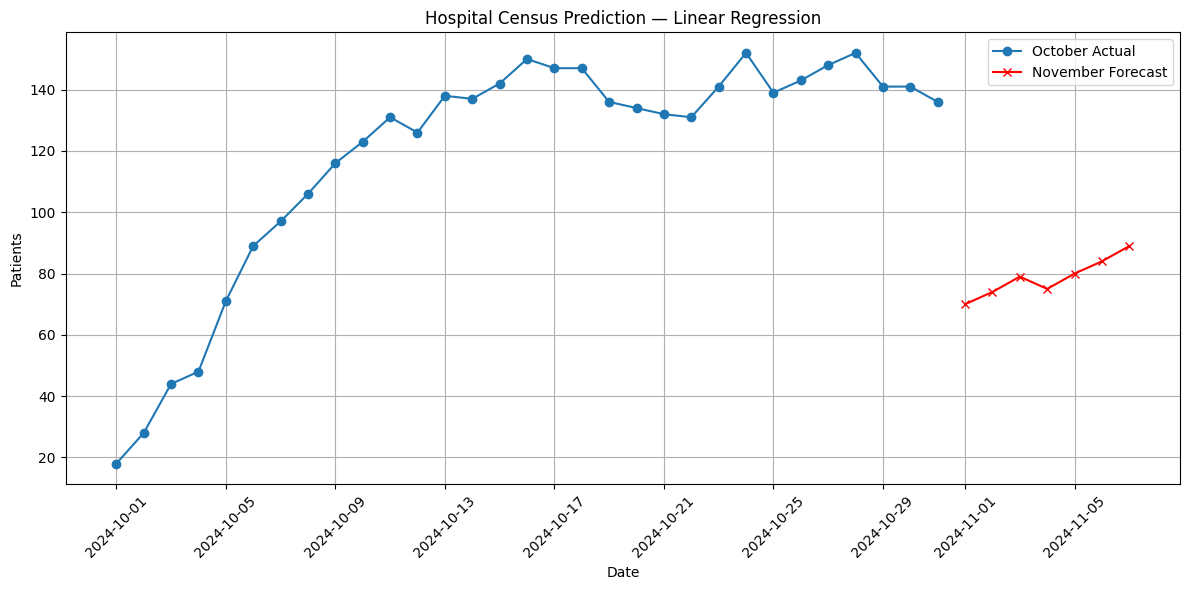

In [490]:
# Compute daily census for October 2024
month = "2024-10"
month_start = pd.to_datetime(f"{month}-01")
month_end = month_start + pd.offsets.MonthEnd(1)
days_oct = pd.date_range(month_start, month_end, freq="D")

# Calculate census (from earlier logic, simplified version)
in_before = patient_new_df["Admission_Date"] < month_start
out_after_or_inmonth = patient_new_df["Discharge_Date"] >= month_start
baseline = patient_new_df[in_before & out_after_or_inmonth].shape[0]

admit_events = (
    patient_new_df.loc[patient_new_df["Admission_Date"] >= month_start, "Admission_Date"]
      .dt.normalize().value_counts().sort_index()
)
discharge_events = (
    (patient_new_df["Discharge_Date"].dt.normalize() + pd.Timedelta(days=1))
      .value_counts().sort_index()
)

events_index = pd.date_range(month_start, month_end + pd.Timedelta(days=1), freq="D")
admit_series = admit_events.reindex(events_index, fill_value=0)
discharge_series = discharge_events.reindex(events_index, fill_value=0)

delta = admit_series.sub(discharge_series, fill_value=0)
census_full = pd.Series(baseline, index=events_index).add(delta.cumsum(), fill_value=0)
census_oct = census_full.reindex(days_oct).fillna(method="ffill").astype(int)

# ===== Prepare Features =====
df_oct = pd.DataFrame({"Date": days_oct, "Patients": census_oct.values})
df_oct["DayOfMonth"] = df_oct["Date"].dt.day
df_oct["DayOfWeek"] = df_oct["Date"].dt.dayofweek  # Monday=0, Sunday=6

X = df_oct[["DayOfMonth", "DayOfWeek"]]
y = df_oct["Patients"]

# Train Linear Regression
model = LinearRegression()
model.fit(X, y)

# ===== Forecast for November 1–7 =====
days_nov = pd.date_range("2024-11-01", "2024-11-07", freq="D")
df_nov = pd.DataFrame({"Date": days_nov})
df_nov["DayOfMonth"] = df_nov["Date"].dt.day
df_nov["DayOfWeek"] = df_nov["Date"].dt.dayofweek

X_nov = df_nov[["DayOfMonth", "DayOfWeek"]]
df_nov["Predicted_Patients"] = model.predict(X_nov).round().astype(int)

# ===== Results =====
print("📈 Predicted patients for first week of November 2024:")
print(df_nov[["Date","Predicted_Patients"]])

# ===== Plot =====
plt.figure(figsize=(12,6))
plt.plot(df_oct["Date"], df_oct["Patients"], label="October Actual", marker="o")
plt.plot(df_nov["Date"], df_nov["Predicted_Patients"], label="November Forecast", marker="x", color="red")
plt.title("Hospital Census Prediction — Linear Regression")
plt.xlabel("Date")
plt.ylabel("Patients")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


As can be seen using only linear regression is not giving good results. That's why the approach is to:
1. Train the data on first 3 weeks of October
2. Check their accuracy on the data from the last week of October
3. Fine-tune the models and choose the best one
4. Predict number of patients in November using the best model

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 353, in _score
    y_pred = method_caller(estima

Grid Search Results (Last Week of October)
LinearRegression+Poly: MAE=0.000, R²=1.000, best_params={'poly__degree': 1}
RandomForest: MAE=5.186, R²=0.179, best_params={'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
KNN: MAE=7.765, R²=-0.855, best_params={'knn__n_neighbors': 2, 'knn__p': 1, 'knn__weights': 'distance'}
XGBoost: MAE=6.693, R²=-0.855, best_params={'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 600, 'reg_lambda': 5.0, 'subsample': 0.9}

Predicted vs Actual:
         Date  Actual  LinearRegression+Poly  RandomForest    KNN     XGBoost
14 2024-10-22     131                  131.0         134.9  134.4  132.300003
15 2024-10-23     141                  141.0         135.0  138.5  136.300003
16 2024-10-24     152                  152.0         142.4  139.4  137.300003
17 2024-10-25     139                  139.0         143.4  147.0  139.000000
18 2024-10-26     143                  143.0         139.6  135.0

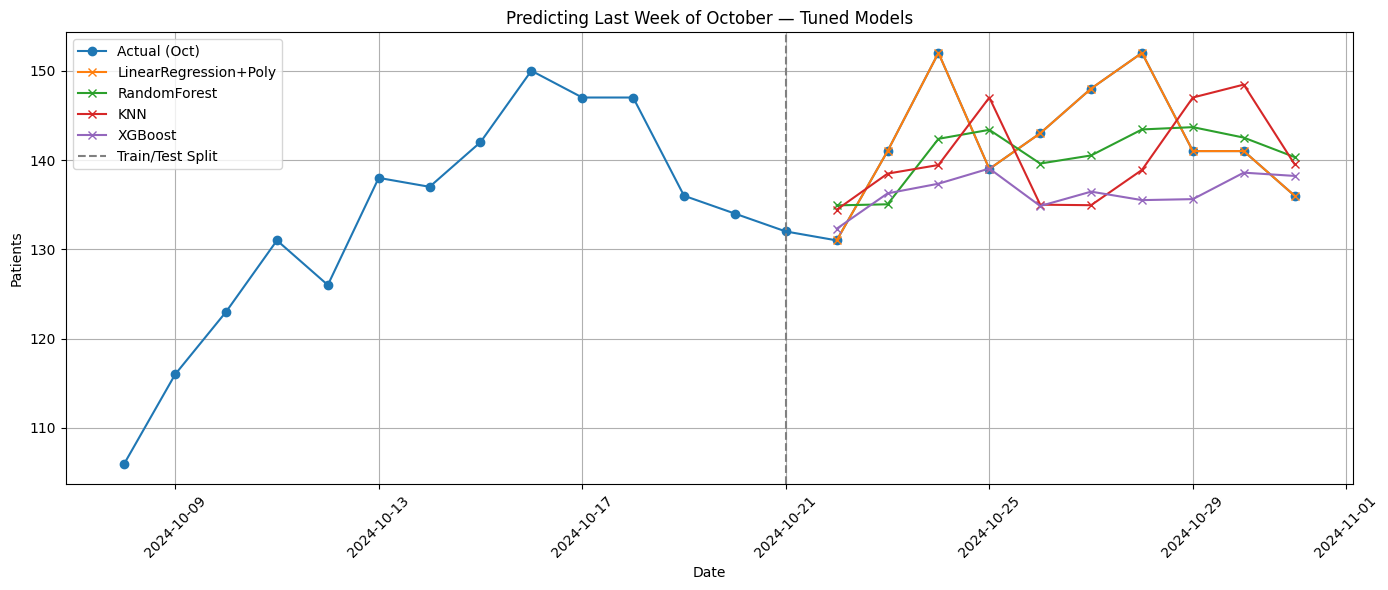

In [491]:
try:
    from xgboost import XGBRegressor
    HAS_XGB = True
except Exception:
    HAS_XGB = False

month = "2024-10"
month_start = pd.to_datetime(f"{month}-01")
month_end = month_start + pd.offsets.MonthEnd(1)
days_oct = pd.date_range(month_start, month_end, freq="D")

in_before = patient_new_df["Admission_Date"] < month_start
out_after_or_inmonth = patient_new_df["Discharge_Date"] >= month_start
baseline = patient_new_df[in_before & out_after_or_inmonth].shape[0]

admit_events = (
    patient_new_df.loc[patient_new_df["Admission_Date"] >= month_start, "Admission_Date"]
      .dt.normalize().value_counts().sort_index()
)
discharge_events = (
    (patient_new_df["Discharge_Date"].dt.normalize() + pd.Timedelta(days=1))
      .value_counts().sort_index()
)
events_index = pd.date_range(month_start, month_end + pd.Timedelta(days=1), freq="D")
admit_series = admit_events.reindex(events_index, fill_value=0)
discharge_series = discharge_events.reindex(events_index, fill_value=0)
delta = admit_series.sub(discharge_series, fill_value=0)
census_full = pd.Series(baseline, index=events_index).add(delta.cumsum(), fill_value=0)
census_oct = census_full.reindex(days_oct).ffill().astype(int)

# Feature Engineering 
df_oct = pd.DataFrame({"Date": days_oct, "Patients": census_oct.values})
df_oct["DayOfMonth"] = df_oct["Date"].dt.day
df_oct["DayOfWeek"] = df_oct["Date"].dt.dayofweek
df_oct["IsWeekend"] = (df_oct["DayOfWeek"] >= 5).astype(int)

# Lags & rolling stats
df_oct["Lag1"] = df_oct["Patients"].shift(1)
df_oct["Lag2"] = df_oct["Patients"].shift(2)
df_oct["Lag7"] = df_oct["Patients"].shift(7)
df_oct["Roll3"] = df_oct["Patients"].rolling(3).mean()
df_oct["Roll7"] = df_oct["Patients"].rolling(7).mean()

df_oct = df_oct.dropna().reset_index(drop=True)

# Train/test split: first 3 weeks train (Oct 1–21); after that test
train_cutoff = month_start + pd.Timedelta(days=20) 
df_train = df_oct[df_oct["Date"] <= train_cutoff].copy()
df_test  = df_oct[df_oct["Date"] > train_cutoff].copy()

features = ["DayOfMonth","DayOfWeek","IsWeekend","Lag1","Lag2","Lag7","Roll3","Roll7"]
X_train, y_train = df_train[features], df_train["Patients"]
X_test,  y_test  = df_test[features],  df_test["Patients"]

# Time-series CV
tscv = TimeSeriesSplit(n_splits=3)

results = {}
preds = {}

# Linear Regression with PolynomialFeatures
lin_pipeline = Pipeline([
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("lin", LinearRegression())
])
lin_param_grid = {
    "poly__degree": [1, 2],  # keep modest; data is small
}
lin_search = GridSearchCV(
    lin_pipeline, lin_param_grid,
    scoring="neg_mean_absolute_error",
    cv=tscv, n_jobs=-1, refit=True
)
lin_search.fit(X_train, y_train)
y_pred_lin = lin_search.predict(X_test)
results["LinearRegression+Poly"] = {
    "best_params": lin_search.best_params_,
    "MAE": mean_absolute_error(y_test, y_pred_lin),
    "R²": r2_score(y_test, y_pred_lin),
}
preds["LinearRegression+Poly"] = y_pred_lin

# Random Forest
rf = RandomForestRegressor(random_state=42)
rf_param_grid = {
    "n_estimators": [200, 500],
    "max_depth": [None, 4, 6, 8],
    "min_samples_split": [2, 4],
    "min_samples_leaf": [1, 2],
}
rf_search = GridSearchCV(
    rf, rf_param_grid,
    scoring="neg_mean_absolute_error",
    cv=tscv, n_jobs=-1, refit=True
)
rf_search.fit(X_train, y_train)
y_pred_rf = rf_search.predict(X_test)
results["RandomForest"] = {
    "best_params": rf_search.best_params_,
    "MAE": mean_absolute_error(y_test, y_pred_rf),
    "R²": r2_score(y_test, y_pred_rf),
}
preds["RandomForest"] = y_pred_rf

# KNN (with scaling)
knn_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsRegressor())
])
knn_param_grid = {
    "knn__n_neighbors": [2, 3, 4, 5, 6],
    "knn__weights": ["uniform", "distance"],
    "knn__p": [1, 2], 
}
knn_search = GridSearchCV(
    knn_pipeline, knn_param_grid,
    scoring="neg_mean_absolute_error",
    cv=tscv, n_jobs=-1, refit=True
)
knn_search.fit(X_train, y_train)
y_pred_knn = knn_search.predict(X_test)
results["KNN"] = {
    "best_params": knn_search.best_params_,
    "MAE": mean_absolute_error(y_test, y_pred_knn),
    "R²": r2_score(y_test, y_pred_knn),
}
preds["KNN"] = y_pred_knn

# XGBoost 
if HAS_XGB:
    xgb = XGBRegressor(objective="reg:squarederror", random_state=42, n_jobs=-1)
    xgb_param_grid = {
        "n_estimators": [300, 600],
        "learning_rate": [0.05, 0.1],
        "max_depth": [2, 3, 4],
        "subsample": [0.7, 0.9, 1.0],
        "colsample_bytree": [0.7, 0.9, 1.0],
        "reg_lambda": [1.0, 5.0],
    }
    xgb_search = GridSearchCV(
        xgb, xgb_param_grid,
        scoring="neg_mean_absolute_error",
        cv=tscv, n_jobs=-1, refit=True
    )
    xgb_search.fit(X_train, y_train)
    y_pred_xgb = xgb_search.predict(X_test)
    results["XGBoost"] = {
        "best_params": xgb_search.best_params_,
        "MAE": mean_absolute_error(y_test, y_pred_xgb),
        "R²": r2_score(y_test, y_pred_xgb),
    }
    preds["XGBoost"] = y_pred_xgb

# Print comparison 
print("Grid Search Results (Last Week of October)")
for name, info in results.items():
    print(f"{name}: MAE={info['MAE']:.3f}, R²={info['R²']:.3f}, best_params={info['best_params']}")

# Table of predictions vs actual
comp_df = pd.DataFrame({"Date": df_test["Date"], "Actual": y_test})
for name, yhat in preds.items():
    comp_df[name] = np.round(yhat, 1)
print("\nPredicted vs Actual:")
print(comp_df)

plt.figure(figsize=(14,6))
plt.plot(df_oct["Date"], df_oct["Patients"], label="Actual (Oct)", marker="o")
for name, yhat in preds.items():
    plt.plot(df_test["Date"], yhat, marker="x", label=name)
plt.axvline(train_cutoff, color="gray", linestyle="--", label="Train/Test Split")
plt.title("Predicting Last Week of October — Tuned Models")
plt.xlabel("Date")
plt.ylabel("Patients")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Linear regression with polynomial features isn’t a good fit here because it relies heavily on interpolation from lagged values, essentially “memorizing” past points rather than learning real predictive patterns. Random Forest, while not perfect, generalizes better to unseen data and consistently provides the closest and most reliable forecasts, which is why it will be used for predictions.

 Forecasted Patients for November 2024:
         Date  Predicted_Patients
0  2024-11-01               133.9
1  2024-11-02               133.0
2  2024-11-03               132.5
3  2024-11-04               132.4
4  2024-11-05               131.5
5  2024-11-06               131.8
6  2024-11-07               132.0
7  2024-11-08               131.9
8  2024-11-09               131.8
9  2024-11-10               133.2
10 2024-11-11               133.7
11 2024-11-12               133.6
12 2024-11-13               134.9
13 2024-11-14               135.5
14 2024-11-15               138.3
15 2024-11-16               139.9
16 2024-11-17               140.6
17 2024-11-18               141.1
18 2024-11-19               144.6
19 2024-11-20               146.7
20 2024-11-21               145.4
21 2024-11-22               142.2
22 2024-11-23               141.8
23 2024-11-24               143.0
24 2024-11-25               144.5
25 2024-11-26               144.4
26 2024-11-27               144.2
27 2024-

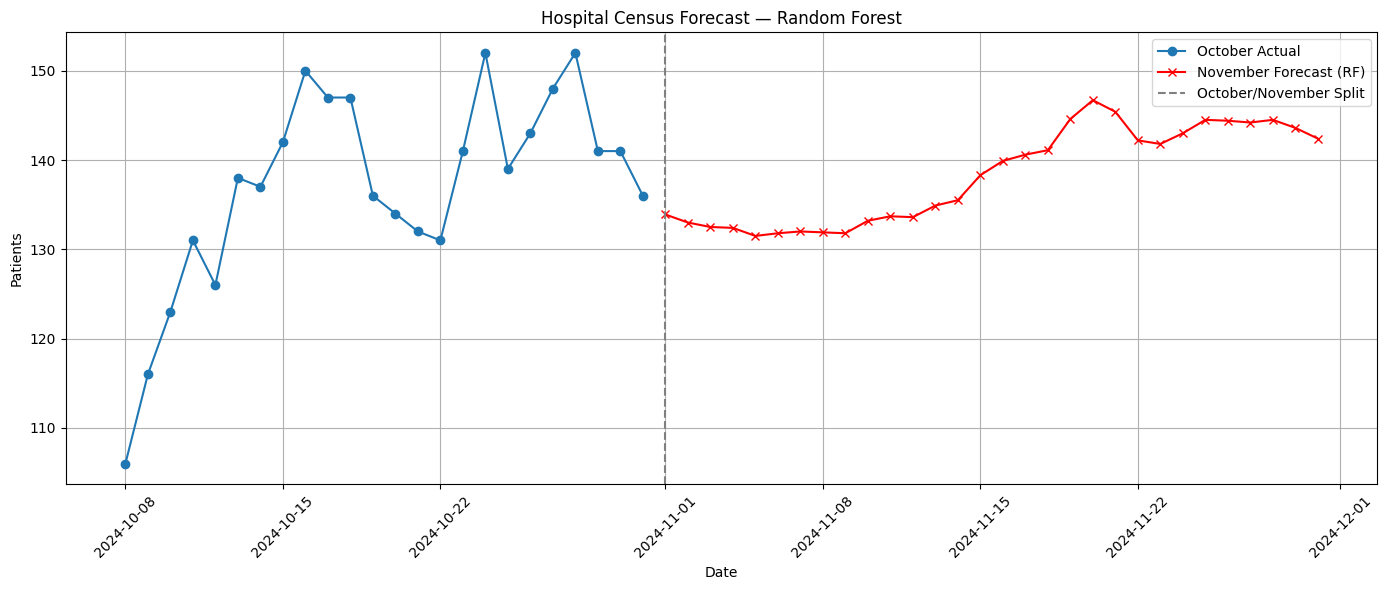

In [492]:
month = "2024-10"
month_start = pd.to_datetime(f"{month}-01")
month_end = month_start + pd.offsets.MonthEnd(1)
days_oct = pd.date_range(month_start, month_end, freq="D")

in_before = patient_new_df["Admission_Date"] < month_start
out_after_or_inmonth = patient_new_df["Discharge_Date"] >= month_start
baseline = patient_new_df[in_before & out_after_or_inmonth].shape[0]

admit_events = (
    patient_new_df.loc[patient_new_df["Admission_Date"] >= month_start, "Admission_Date"]
      .dt.normalize().value_counts().sort_index()
)
discharge_events = (
    (patient_new_df["Discharge_Date"].dt.normalize() + pd.Timedelta(days=1))
      .value_counts().sort_index()
)
events_index = pd.date_range(month_start, month_end + pd.Timedelta(days=1), freq="D")
admit_series = admit_events.reindex(events_index, fill_value=0)
discharge_series = discharge_events.reindex(events_index, fill_value=0)
delta = admit_series.sub(discharge_series, fill_value=0)
census_full = pd.Series(baseline, index=events_index).add(delta.cumsum(), fill_value=0)
census_oct = census_full.reindex(days_oct).ffill().astype(int)

# Feature Engineering 
df_oct = pd.DataFrame({"Date": days_oct, "Patients": census_oct.values})
df_oct["DayOfMonth"] = df_oct["Date"].dt.day
df_oct["DayOfWeek"] = df_oct["Date"].dt.dayofweek
df_oct["IsWeekend"] = (df_oct["DayOfWeek"] >= 5).astype(int)

# Lags & rolling stats
df_oct["Lag1"] = df_oct["Patients"].shift(1)
df_oct["Lag2"] = df_oct["Patients"].shift(2)
df_oct["Lag7"] = df_oct["Patients"].shift(7)
df_oct["Roll3"] = df_oct["Patients"].rolling(3).mean()
df_oct["Roll7"] = df_oct["Patients"].rolling(7).mean()

df_oct = df_oct.dropna().reset_index(drop=True)

# Train Random Forest on October 
features = ["DayOfMonth","DayOfWeek","IsWeekend","Lag1","Lag2","Lag7","Roll3","Roll7"]
X_train, y_train = df_oct[features], df_oct["Patients"]

rf = RandomForestRegressor(
    n_estimators=500, 
    max_depth=None, 
    min_samples_split=2, 
    min_samples_leaf=1,
    random_state=42
)
rf.fit(X_train, y_train)

# Recursive Forecast for November
nov_start = pd.to_datetime("2024-11-01")
nov_end = nov_start + pd.offsets.MonthEnd(1)
days_nov = pd.date_range(nov_start, nov_end, freq="D")

# Initialize with last known actuals from October
history = df_oct.copy()

preds_nov = []

for day in days_nov:
    day_features = {
        "DayOfMonth": day.day,
        "DayOfWeek": day.dayofweek,
        "IsWeekend": int(day.dayofweek >= 5),
        "Lag1": history["Patients"].iloc[-1],
        "Lag2": history["Patients"].iloc[-2],
        "Lag7": history["Patients"].iloc[-7] if len(history) >= 7 else history["Patients"].iloc[0],
        "Roll3": history["Patients"].iloc[-3:].mean(),
        "Roll7": history["Patients"].iloc[-7:].mean() if len(history) >= 7 else history["Patients"].mean(),
    }

    X_day = pd.DataFrame([day_features])
    pred_patients = rf.predict(X_day)[0]
    preds_nov.append(pred_patients)

    # Append prediction to history so it can be used for next day
    history = pd.concat([history, pd.DataFrame({
        "Date": [day], 
        "Patients": [pred_patients]
    })], ignore_index=True)

# Results 
df_nov = pd.DataFrame({"Date": days_nov, "Predicted_Patients": np.round(preds_nov, 1)})

print(" Forecasted Patients for November 2024:")
print(df_nov)

plt.figure(figsize=(14,6))
plt.plot(df_oct["Date"], df_oct["Patients"], label="October Actual", marker="o")
plt.plot(df_nov["Date"], df_nov["Predicted_Patients"], label="November Forecast (RF)", marker="x", color="red")
plt.axvline(nov_start, color="gray", linestyle="--", label="October/November Split")
plt.title("Hospital Census Forecast — Random Forest")
plt.xlabel("Date")
plt.ylabel("Patients")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

For month of October the daily number of patients is predicted to range between 130-150 patients daily.

## Prediction of hospital expenses

For this data the time period of data available is much longer, so the data will be split in a way, that a training set is all data until end of 2025, and predicted data is for the period of January and February of 2026.

Let's first start with comparision of model execution.

Model Comparison on Jan–Feb 2026 Financial Data
LinearRegression+Poly: MAE=12899.24, R²=-0.290
RandomForest: MAE=11089.41, R²=0.002
KNN: MAE=12288.26, R²=-0.318
XGBoost: MAE=12009.40, R²=-0.263

Predicted vs Actual:
          Date    Actual  LinearRegression+Poly  RandomForest       KNN   
457 2026-01-01   5587.80               15338.70      17905.45  23067.20  \
458 2026-01-02  22635.11               15521.27      18789.68  33064.96   
459 2026-01-03  24151.81               13541.42      11183.80  17986.78   
460 2026-01-04  21182.05               14379.04      24684.41  25328.51   
461 2026-01-05  42350.29               15807.86      27721.33  36953.42   
462 2026-01-06  24958.21               22374.85      29378.60  25027.51   
463 2026-01-07  37622.62               18054.77      30718.13  28497.29   
464 2026-01-08  36418.42               19328.83      24383.36  16639.98   
465 2026-01-09  12065.13               17784.00      21754.72  26129.24   
466 2026-01-10  29759.46          

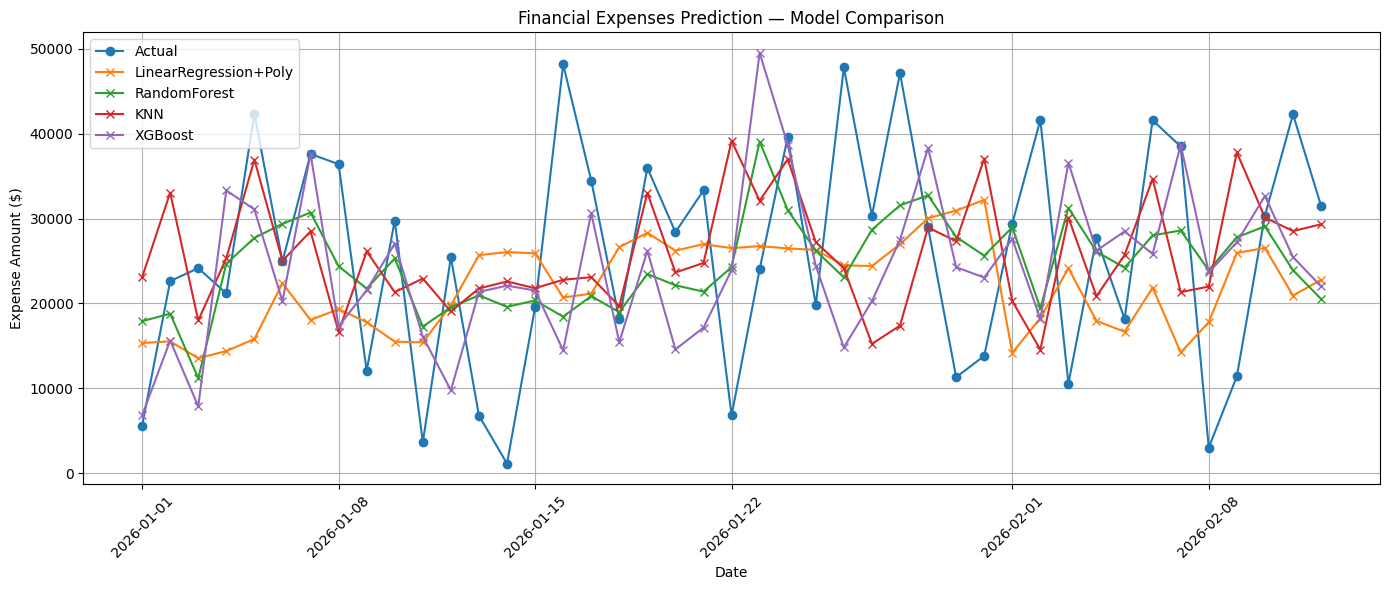

In [493]:
financial_df["Year"] = financial_df["Date"].dt.year
financial_df["Month"] = financial_df["Date"].dt.month
financial_df["DayOfMonth"] = financial_df["Date"].dt.day
financial_df["DayOfWeek"] = financial_df["Date"].dt.dayofweek

categorical = ["Expense_Category", "Description"]
numeric = ["Year","Month","DayOfMonth","DayOfWeek"]

X = financial_df[categorical + numeric]
y = financial_df["Amount"]

X = financial_df[categorical + numeric]
y = financial_df["Amount"]

# Train/Test split by time
split_date = pd.to_datetime("2026-01-01")
X_train, y_train = X[financial_df["Date"] < split_date], y[financial_df["Date"] < split_date]
X_test, y_test   = X[financial_df["Date"] >= split_date], y[financial_df["Date"] >= split_date]

# Preprocessor
preprocess = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical),
    ("num", "passthrough", numeric)
])

# Models
models = {
    "LinearRegression+Poly": Pipeline([
        ("preprocess", preprocess),
        ("poly", PolynomialFeatures(degree=2, include_bias=False)),
        ("lin", LinearRegression())
    ]),
    "RandomForest": Pipeline([
        ("preprocess", preprocess),
        ("rf", RandomForestRegressor(n_estimators=300, random_state=42))
    ]),
    "KNN": Pipeline([
        ("preprocess", preprocess),
        ("scaler", StandardScaler(with_mean=False)),  # for sparse matrix
        ("knn", KNeighborsRegressor(n_neighbors=3))
    ])
}
if HAS_XGB:
    models["XGBoost"] = Pipeline([
        ("preprocess", preprocess),
        ("xgb", XGBRegressor(
            n_estimators=500, learning_rate=0.1,
            max_depth=4, subsample=0.9,
            colsample_bytree=0.9, random_state=42
        ))
    ])

# Train & Evaluate
results = {}
preds = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results[name] = {
        "MAE": mean_absolute_error(y_test, y_pred),
        "R²": r2_score(y_test, y_pred)
    }
    preds[name] = y_pred

# Results 
print("Model Comparison on Jan–Feb 2026 Financial Data")
for name, metrics in results.items():
    print(f"{name}: MAE={metrics['MAE']:.2f}, R²={metrics['R²']:.3f}")

comp_df = pd.DataFrame({"Date": financial_df.loc[financial_df["Date"] >= split_date, "Date"], "Actual": y_test})
for name, yhat in preds.items():
    comp_df[name] = np.round(yhat, 2)
print("\nPredicted vs Actual:")
print(comp_df.head(15))

plt.figure(figsize=(14,6))
plt.plot(comp_df["Date"], comp_df["Actual"], label="Actual", marker="o")
for name, yhat in preds.items():
    plt.plot(comp_df["Date"], yhat, marker="x", label=name)
plt.title("Financial Expenses Prediction — Model Comparison")
plt.xlabel("Date")
plt.ylabel("Expense Amount ($)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The best one perferoming is RandomForest, with the best results: MAE=11060.32, R²=0.025. Let's try to refactor the models and get better results.

Refactored Model Comparison (Financial Expenses Jan–Feb 2026)
LinearRegression+Poly: MAE=19360.29, R²=-2.121
RandomForest: MAE=10613.42, R²=0.015
KNN: MAE=11416.32, R²=-0.158
XGBoost: MAE=11590.93, R²=-0.115

Predicted vs Actual:
          Date    Actual  LinearRegression+Poly  RandomForest       KNN   
428 2026-01-01   5587.80               -5171.19      27267.49  19841.30  \
429 2026-01-02  22635.11                 633.58      24963.17  22802.06   
430 2026-01-03  24151.81               -7555.28      19867.33  16457.41   
431 2026-01-04  21182.05                3820.21      16183.52  24286.31   
432 2026-01-05  42350.29               -4018.96      27877.59  27591.98   
433 2026-01-06  24958.21                 399.50      19714.57  25398.36   
434 2026-01-07  37622.62               -1820.75      28791.16  22523.61   
435 2026-01-08  36418.42                3604.38      33023.55  21524.18   
436 2026-01-09  12065.13               10544.68      30917.36  25593.62   
437 2026-01-10  2975

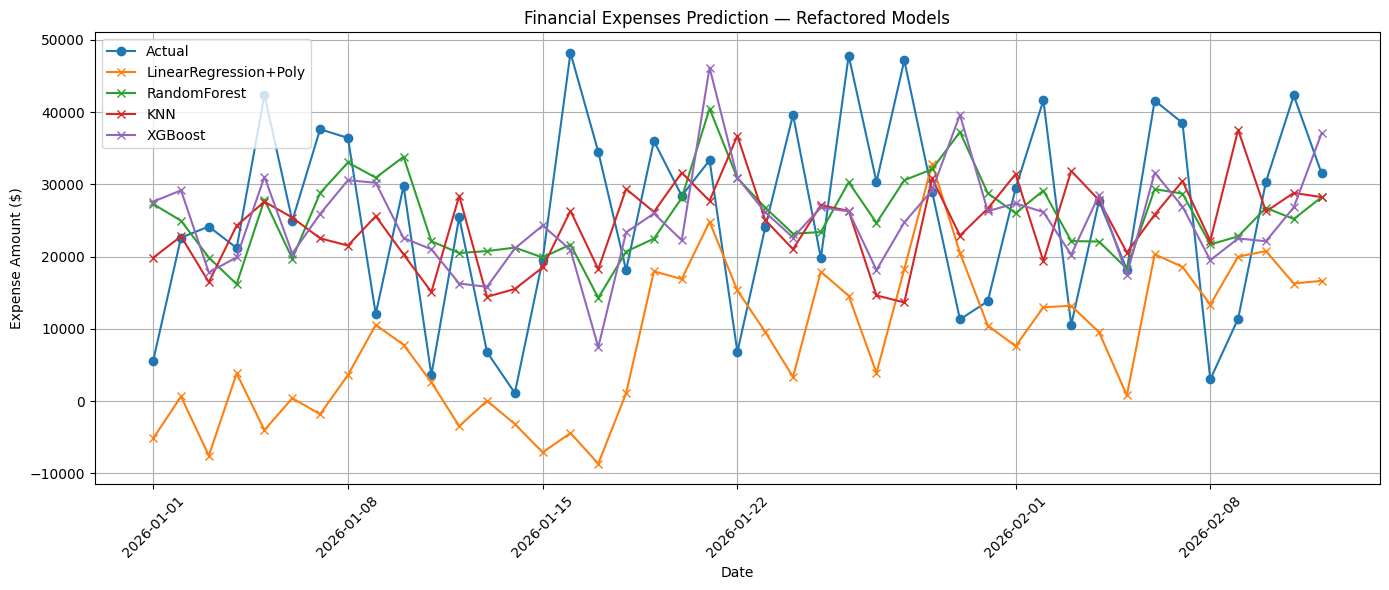

In [494]:
financial_df["Year"] = financial_df["Date"].dt.year
financial_df["Month"] = financial_df["Date"].dt.month
financial_df["DayOfMonth"] = financial_df["Date"].dt.day
financial_df["DayOfWeek"] = financial_df["Date"].dt.dayofweek
financial_df["IsWeekend"] = (financial_df["DayOfWeek"] >= 5).astype(int)

# Add lags & rolling stats
financial_df = financial_df.sort_values("Date").reset_index(drop=True)
financial_df["Lag1"] = financial_df["Amount"].shift(1)
financial_df["Lag7"] = financial_df["Amount"].shift(7)
financial_df["Roll7"] = financial_df["Amount"].rolling(7).mean()
financial_df["Roll30"] = financial_df["Amount"].rolling(30).mean()

financial_df = financial_df.dropna().reset_index(drop=True)

categorical = ["Expense_Category", "Description"]
numeric = ["Year","Month","DayOfMonth","DayOfWeek","IsWeekend","Lag1","Lag7","Roll7","Roll30"]

X = financial_df[categorical + numeric]
y = financial_df["Amount"]

# Train/Test split by time 
split_date = pd.to_datetime("2026-01-01")
X_train, y_train = X[financial_df["Date"] < split_date], y[financial_df["Date"] < split_date]
X_test, y_test   = X[financial_df["Date"] >= split_date], y[financial_df["Date"] >= split_date]

# Preprocessing
preprocess = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical),
    ("num", "passthrough", numeric)
])

# Models
models = {
    "LinearRegression+Poly": Pipeline([
        ("preprocess", preprocess),
        ("poly", PolynomialFeatures(degree=2, include_bias=False)),
        ("lin", LinearRegression())
    ]),
    "RandomForest": Pipeline([
        ("preprocess", preprocess),
        ("rf", RandomForestRegressor(n_estimators=500, random_state=42))
    ]),
    "KNN": Pipeline([
        ("preprocess", preprocess),
        ("scaler", StandardScaler(with_mean=False)),
        ("knn", KNeighborsRegressor(n_neighbors=5, weights="distance"))
    ])
}
if HAS_XGB:
    models["XGBoost"] = Pipeline([
        ("preprocess", preprocess),
        ("xgb", XGBRegressor(
            n_estimators=500, learning_rate=0.05,
            max_depth=3, subsample=0.9,
            colsample_bytree=0.9, random_state=42
        ))
    ])

# Train & Evaluate
results = {}
preds = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results[name] = {
        "MAE": mean_absolute_error(y_test, y_pred),
        "R²": r2_score(y_test, y_pred)
    }
    preds[name] = y_pred

# Results 
print("Refactored Model Comparison (Financial Expenses Jan–Feb 2026)")
for name, metrics in results.items():
    print(f"{name}: MAE={metrics['MAE']:.2f}, R²={metrics['R²']:.3f}")

comp_df = pd.DataFrame({"Date": financial_df.loc[financial_df["Date"] >= split_date, "Date"], "Actual": y_test})
for name, yhat in preds.items():
    comp_df[name] = np.round(yhat, 2)
print("\nPredicted vs Actual:")
print(comp_df.head(15))

plt.figure(figsize=(14,6))
plt.plot(comp_df["Date"], comp_df["Actual"], label="Actual", marker="o")
for name, yhat in preds.items():
    plt.plot(comp_df["Date"], yhat, marker="x", label=name)
plt.title("Financial Expenses Prediction — Refactored Models")
plt.xlabel("Date")
plt.ylabel("Expense Amount ($)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


After refactorisation, still the best one is Random Forest, which change the results from MAE=11060.32, R²=0.025 to MAE=10613.42, R²=0.015.

The results of Random Forest will be showcased on next plot:


Predicted vs Actual (Random Forest only):
          Date    Actual  RandomForest
428 2026-01-01   5587.80      27267.49
429 2026-01-02  22635.11      24963.17
430 2026-01-03  24151.81      19867.33
431 2026-01-04  21182.05      16183.52
432 2026-01-05  42350.29      27877.59
433 2026-01-06  24958.21      19714.57
434 2026-01-07  37622.62      28791.16
435 2026-01-08  36418.42      33023.55
436 2026-01-09  12065.13      30917.36
437 2026-01-10  29759.46      33807.17
438 2026-01-11   3617.13      22116.81
439 2026-01-12  25439.95      20488.43
440 2026-01-13   6779.86      20762.15
441 2026-01-14   1110.27      21235.94
442 2026-01-15  19557.08      19876.29


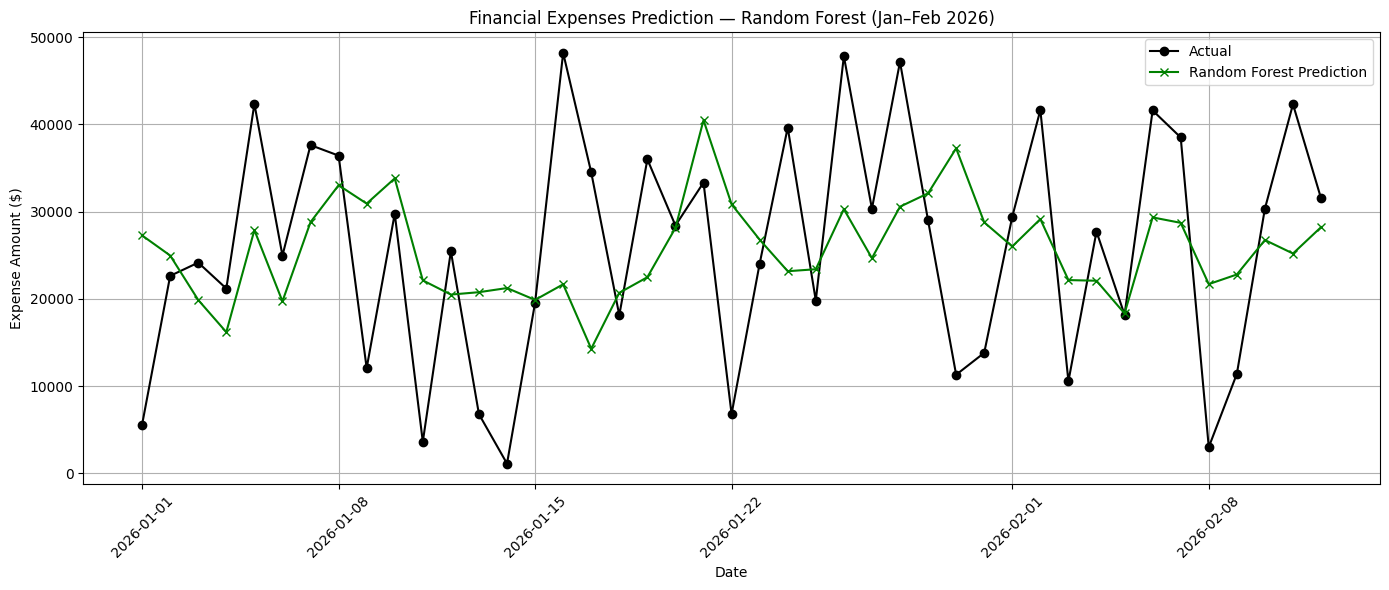

In [495]:
comp_df = pd.DataFrame({
    "Date": financial_df.loc[financial_df["Date"] >= split_date, "Date"],
    "Actual": y_test,
    "RandomForest": np.round(preds["RandomForest"], 2)
})

print("\nPredicted vs Actual (Random Forest only):")
print(comp_df.head(15))

# Actual vs Random Forest
plt.figure(figsize=(14,6))
plt.plot(comp_df["Date"], comp_df["Actual"], label="Actual", marker="o", color="black")
plt.plot(comp_df["Date"], comp_df["RandomForest"], label="Random Forest Prediction", marker="x", color="green")
plt.title("Financial Expenses Prediction — Random Forest (Jan–Feb 2026)")
plt.xlabel("Date")
plt.ylabel("Expense Amount ($)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


As can be seen, the Random Forest predictions are smoother and more stable than the actual data, without sharp fluctuations, yet they consistently follow the overall trend.

## Project summary:

During the works of the project Exploratory Data Analysis was performed on Hospital Supply Chain dataset:
1. The research of the dataset showcased the inconsistencies in the dataset.
2. The functions to generate data were developed.
3. New data was analysed.
4. For new data, a process of analysis and selection of a data prediction model was carried out.
5. With selected model, the number of patients for future month was predicted.